Project Description
In this capstone project, the goal is to build a pneumonia detection system, to locate the position of
inflammation in an image.
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear
black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia
related.
In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates
that while pneumonia was determined not to be present, there was nonetheless some type of
abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.
Details about the data and dataset files are given in below link,
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
Pre-Processing, Data Visualization, EDA
 Exploring the given Data files, classes and images of different classes.
 Dealing with missing values
 Visualization of different classes
 Analysis from the visualization of different classes.
Model Building
 Building a pneumonia detection model starting from basic CNN and then improving upon it.
 Train the model
 To deal with large training time, save the weights so that you can use them when training the
model for the second time without starting from scratch.
Test the Model, Fine-tuning and Repeat
 Test the model and report as per evaluation metrics
 Try different models
 Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning
rate, batch size, checkpointing, early stopping etc. for these models to fine-tune them
 Report evaluation metrics for these models along with your observation on how changing
different hyper parameters leads to change in the final evaluation metric.



## Data importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os; os.chdir('/content/drive/MyDrive/Capstone')

In [ ]:
rm masks*.jpg

In [ ]:
ls

'GCP Credits Request Link - RSNA.txt'   stage_2_sample_submission.csv
 image_jpeg/                            stage_2_test_images/
 images_train_df.pkl                    stage_2_train_images/
 masks/                                 stage_2_train_labels.csv
 stage_2_detailed_class_info.csv


In [ ]:
! pip install pydicom

     |████████████████████████████████| 2.0 MB 9.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pydicom as dcm
import os
import cv2
import gc
import glob
from tqdm import tqdm
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input
import warnings
warnings.filterwarnings("ignore")

## Reading the csv input data

In [ ]:
labels_df=pd.read_csv('stage_2_train_labels.csv')

In [ ]:
labels_df.head(5)

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

### Data information
* Labels csv consists of PatientId, 
* Bounding box X,Y positions and Its Width and Height
* Target whether the Image has Pnuemonia or not.
* If the patient doesnt have Pnuemonia the bounding box coordinates are NAN

In [ ]:
##Identify duplicates records in the data
dupes = labels_df.duplicated()
sum(dupes)

0

In [ ]:
class_df=pd.read_csv('stage_2_detailed_class_info.csv')

In [ ]:
class_df.head(5)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

### Data information
* Target Variable with Pnuemonia is distinquished as Lung Opacity
* Target variable without Pnuemonia is divided into two classes No Lung Opacity/Not Normal and Normal

# EDA on dataset

In [ ]:
labels_df.shape

(30227, 6)

In [ ]:
class_df.shape

(30227, 2)

In [ ]:
labels_class=pd.concat([labels_df,class_df['class']],axis=1)

In [ ]:
labels_class = labels_class.drop_duplicates()

In [ ]:
labels_class.shape

(30227, 7)

In [ ]:
labels_class['patientId'].nunique()

26684

### Observations
* No. of patients is not the same as total number of data.
* This shows few patients might has more number of Pnuemonia locations in image and hence more number of Boxes

In [ ]:
labels_class.head(5)

patientId  ...                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity

[5 rows x 7 columns]

In [ ]:
labels_class.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

In [ ]:
print(labels_class['Target'].value_counts())

0    20672
1     9555
Name: Target, dtype: int64


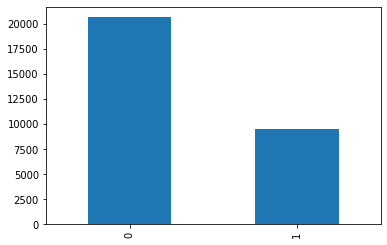

In [ ]:
labels_class.Target.value_counts().plot(kind = 'bar')
plt.show()

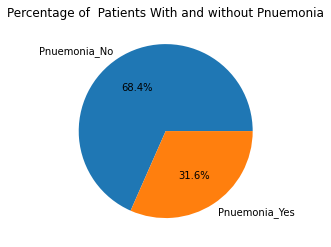

In [ ]:
#Pie Chart
labels = ['Pnuemonia_No', 'Pnuemonia_Yes']
plt.pie(labels_class['Target'].value_counts(), labels = labels, autopct='%1.1f%%')
plt.title("Percentage of  Patients With and without Pnuemonia")
plt.show()

In [ ]:
print(labels_class['class'].value_counts())

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


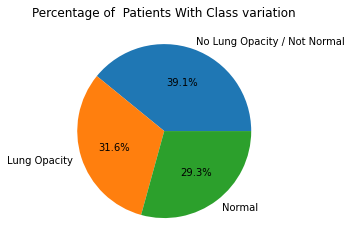

In [ ]:
#Pie Chart
labels = ['No Lung Opacity / Not Normal', 'Lung Opacity','Normal']
plt.pie(labels_class['class'].value_counts(), labels = labels, autopct='%1.1f%%')
plt.title("Percentage of  Patients With Class variation")
plt.show()

In [ ]:
pd.crosstab(labels_class['class'], labels_class['Target'],margins=True)

Target                            0     1    All
class                                           
Lung Opacity                      0  9555   9555
No Lung Opacity / Not Normal  11821     0  11821
Normal                         8851     0   8851
All                           20672  9555  30227

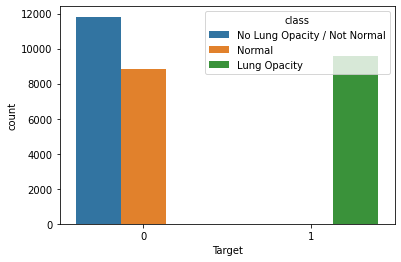

In [ ]:
sns.countplot(x='Target',data=labels_class,hue ='class');

## Observations
* Out of 68.4% Having no Pnuemonia 39.1% has class of No lung Opacity/Not Normal and 29.3% with clas as Normal

## Checking the Patients who has more locations of  Pnuemonia  or bounding boxes
* No. of Nulls for the boundary boxes matches with number of target class of No Pnuemonia.( 20672)
* Out of 9555 Pnueomia there might be duplicate patients who has more than one bounding box

In [ ]:
print(labels_class.groupby('patientId')['Target'].size().sort_values(ascending = False))

patientId
76f71a93-8105-4c79-a010-0cfa86f0061a    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
                                       ..
6b1319bc-6253-47b8-9f36-c694bef288d0    1
6b110a37-e31c-437d-8886-c2e7cd5b2cb2    1
6b10737e-ec37-4f37-8db3-a95434db6016    1
6b0fa27d-7ca7-4b56-92c7-a389988ec660    1
fffec09e-8a4a-48b1-b33e-ab4890ccd136    1
Name: Target, Length: 26684, dtype: int64


In [ ]:
labels_class_target1 = labels_class.loc[(labels_class['Target'] ==1)]
labels_class_target1.shape

(9555, 7)

In [ ]:
print(labels_class_target1.groupby('patientId')['Target'].size().sort_values(ascending = False))

patientId
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
7d674c82-5501-4730-92c5-d241fd6911e7    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
                                       ..
3b4decc7-fed9-46fd-9d30-179b7cde4a2c    1
3b4a83a5-e755-4b20-b21c-0a0424095325    1
a2d27e14-d9c0-4596-84d8-c526b0afc9a7    1
a2ddccd7-9c2b-4d81-9375-928b418da482    1
35726244-0298-433e-9376-d1a1fe5724cf    1
Name: Target, Length: 6012, dtype: int64


In [ ]:
print(labels_class_target1.groupby('patientId')['Target'].size().sort_values(ascending = False).value_counts())

2    3266
1    2614
3     119
4      13
Name: Target, dtype: int64


## Observations
* We do have 6012 patients who has Pnuemonia and rest 20672 patients without Pnuemonia
* Out of 6012 patients 12 have 4 bounding boxes,119 with 3,2614 with 1 and 3266 with 2 boxes
* There is high class imbalance

## Checking the Majority of Rectangular box locations on the lungs
* Center of the Box is plotted to understand the position of box over two lungs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


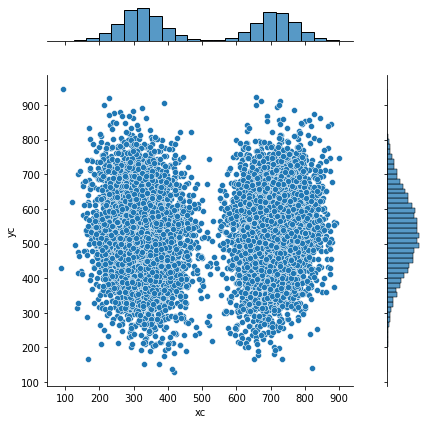

In [ ]:
labels_class_target1['xc'] = labels_class_target1['x'] + labels_class_target1['width']/2
labels_class_target1['yc'] = labels_class_target1['y'] + labels_class_target1['height']/2

sns.jointplot(x = labels_class_target1['xc'], y = labels_class_target1['yc'], data = labels_class_target1,
                  kind = 'scatter',space=1)

In [ ]:
print(labels_class_target1['yc'].mean())

531.4744113029827


### Observations
* We can see two lungs having Pnuemonia detected rectangular boxes with majority at center of lungs
* Could see few outlier boxes which may or may not have proper boxes which has Pnuemonia and might be the boxes are not on the lungs itself

# Reading the Images

In [ ]:
dcm_images = dcm.dcmread('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')

In [ ]:
print(dcm_images)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

## Observations
* Based on the DCM file we see that the important parameters that can be extracted are
* Patient Age
* Patient Sex
* Picture size ( RowsXColumns) - Helpful for CNN
* View position -AP or PV - This is important  whether the receptor board is close to the Chest or back of the Chest
* Pixel spacing- Distance the object Vs Image receptor where the picture is captured

In [ ]:
images_df=labels_class.copy()

In [ ]:
from pathlib import Path
data = Path('stage_2_train_images')
train_images=list(data.glob('*.dcm'))

In [ ]:
len(train_images)

26684

In [ ]:
images = []
for img in glob.glob("stage_2_train_images/*.dcm"):
    image_dcm = dcm.read_file(img)
    images.append(image_dcm)
        


## Train and Test images

In [ ]:
for img in glob.glob("stage_2_train_images/*.dcm"):
    image_dcm = dcm.read_file(img)
    idx = (images_df['patientId'] == image_dcm.PatientID)
    images_df.loc[idx, 'PatientAge'] = pd.to_numeric(image_dcm.PatientAge)
    images_df.loc[idx, 'PatientSex'] = image_dcm.PatientSex
    images_df.loc[idx, 'ViewPosition'] = image_dcm.ViewPosition
    images_df.loc[idx, 'Rows'] = image_dcm.Rows
    images_df.loc[idx, 'Columns'] = image_dcm.Columns
    images_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", image_dcm.PixelSpacing[0])

In [ ]:
images_df.to_pickle("images_train_df.pkl")

In [ ]:
images_df.to_csv('images_train_excel.csv',index=False)

In [ ]:
import pickle

In [ ]:
with open('trainimagesdata.pkl', 'wb') as f:
    pickle.dump(images, f)

# EDA with Image data for Train and Test

In [ ]:
images_df = pd.read_pickle('images_train_df.pkl')

In [ ]:
images_df.head(3)

patientId   x   y  ...    Rows  Columns  PixelSpacing
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN  ...  1024.0   1024.0         0.143
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN  ...  1024.0   1024.0         0.194
2  00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN  ...  1024.0   1024.0         0.168

[3 rows x 13 columns]

### Test images data frame

In [ ]:
test_df=images_df.copy()

In [ ]:
test_df.drop(test_df.index, inplace=True)

In [ ]:
test_df.drop(['x','y','width','height','Target','class'],inplace=True, axis=1)

In [ ]:
dcm_test = dcm.dcmread('stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm')

In [ ]:
print(dcm_test)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10118.1517874346.924223
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
idx =0
for img in glob.glob("stage_2_test_images/*.dcm"):
    image_dcm = dcm.read_file(img)
    test_df.loc[idx, 'patientId'] = image_dcm.PatientID
    test_df.loc[idx, 'PatientAge'] = pd.to_numeric(image_dcm.PatientAge)
    test_df.loc[idx, 'PatientSex'] = image_dcm.PatientSex
    test_df.loc[idx, 'ViewPosition'] = image_dcm.ViewPosition
    test_df.loc[idx, 'Rows'] = image_dcm.Rows
    test_df.loc[idx, 'Columns'] = image_dcm.Columns
    test_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", image_dcm.PixelSpacing[0])
    idx=idx+1

In [ ]:
test_df.head()

patientId  PatientAge  ... Columns PixelSpacing
0  2602635c-7751-44db-82b3-ea47dd399121        50.0  ...  1024.0        0.168
1  258f5240-8010-4472-91fe-494f75d59a46        22.0  ...  1024.0        0.171
2  255952dd-d7d1-4329-a713-43039c15e2f3        59.0  ...  1024.0        0.139
3  263db843-751f-4cd1-b392-548fe40d2636        54.0  ...  1024.0        0.139
4  24f7c131-9d07-4251-83fc-20ab9079e326        50.0  ...  1024.0        0.194

[5 rows x 7 columns]

### Train and test images in dataframe

In [ ]:
test_images = []
for img in glob.glob("stage_2_test_images/*.dcm"):
    image_dcm = dcm.read_file(img)
    test_images.append(image_dcm)

In [ ]:
with open('trainimagesdata.pkl', 'rb') as f:
    train_images = pickle.load(f)

In [ ]:
images_df.head()

patientId      x  ...  Columns  PixelSpacing
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN  ...   1024.0         0.143
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN  ...   1024.0         0.194
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN  ...   1024.0         0.168
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN  ...   1024.0         0.143
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  ...   1024.0         0.139

[5 rows x 13 columns]

In [ ]:
print(images_df['Rows'].min())
print(images_df['Rows'].max())
print(images_df['Rows'].mean())

1024.0
1024.0
1024.0


In [ ]:
print(images_df['Columns'].min())
print(images_df['Columns'].max())
print(images_df['Columns'].mean())

1024.0
1024.0
1024.0


## Observations
* Looks like the images are of same size and hence we can delete this attribute

In [ ]:
train_df = images_df.copy()

In [ ]:
train_df['x'] = train_df['x'].fillna(0)
train_df['y'] = train_df['y'].fillna(0)
train_df['width'] = train_df['width'].fillna(0)
train_df['height'] = train_df['height'].fillna(0)

In [ ]:
train_df['xc'] = train_df['x'] + train_df['width']/2
train_df['yc'] = train_df['y'] + train_df['height']/2

In [ ]:
train_df['Area'] = train_df['x']*train_df['width']

In [ ]:
train_df=train_df.drop(['Rows','Columns'],axis=1)

In [ ]:
train_df.shape

(30227, 14)

In [ ]:
train_dp = train_df.drop_duplicates(subset=['patientId'])

In [ ]:
train_dp.shape

(26684, 14)

### Percentage of Patients with and Without Pnuemonia

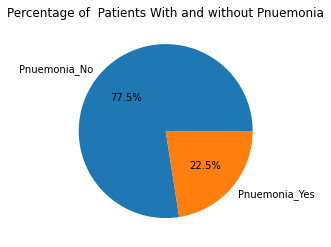

In [ ]:
#Pie Chart
labels = ['Pnuemonia_No', 'Pnuemonia_Yes']
plt.pie(train_dp['Target'].value_counts(), labels = labels, autopct='%1.1f%%')
plt.title("Percentage of  Patients With and without Pnuemonia")
plt.show()

In [ ]:
len(train_dp.loc[train_dp['Target'] == 1])

6012

### Patients with Pnuemonia and Male Female Ratio

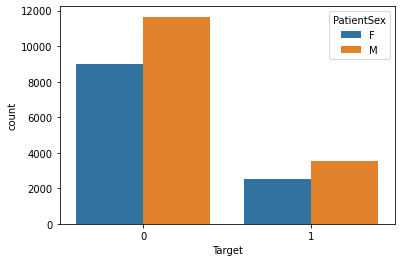

In [ ]:
sns.countplot(x='Target',data=train_dp,hue ='PatientSex');

In [ ]:
pd.crosstab(train_dp['Target'], train_dp['PatientSex'],margins=True)

PatientSex      F      M    All
Target                         
0            9016  11656  20672
1            2502   3510   6012
All         11518  15166  26684

* Male Patients affected with Pnuemonia is high compared to Female
* X ray taken for Male Patients are also high

### Patients with Pnuemonia and Position of XRay taken
### Overall Patients with Position of XRay taken

In [ ]:
pd.crosstab(train_dp['Target'], train_dp['ViewPosition'],margins=True)

ViewPosition     AP     PA    All
Target                           
0              7509  13163  20672
1              4664   1348   6012
All           12173  14511  26684

In [ ]:
pd.crosstab(train_dp['Target'], train_dp['ViewPosition'],margins=True,normalize='index')

ViewPosition        AP        PA
Target                          
0             0.363245  0.636755
1             0.775782  0.224218
All           0.456191  0.543809

* Patients taken with AP Posture ( Normally sick already) has higher chances of Pnuemonia - Close to 77% out of total Pnuemonia patients
* Clustering the images into AP and PA has good chances of predictions of Pnuemonia
* Percentage of people with PA Posture are higher


### Patients with Pnuemonia and Age group

<Figure size 1080x1080 with 0 Axes>

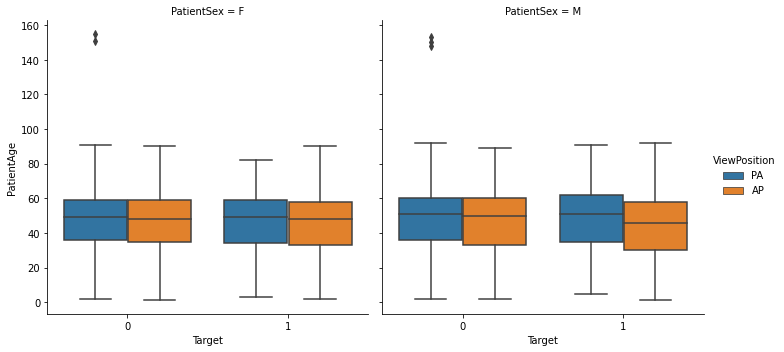

In [ ]:
plt.figure(figsize=(15,15))
sns.catplot(x="Target",
               y = "PatientAge",
               hue="ViewPosition", 
               col="PatientSex",
               data=train_dp, 
               kind="box");

In [ ]:
train_dp["PixelSpacing"] = train_dp.PixelSpacing.astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<Figure size 1080x1080 with 0 Axes>

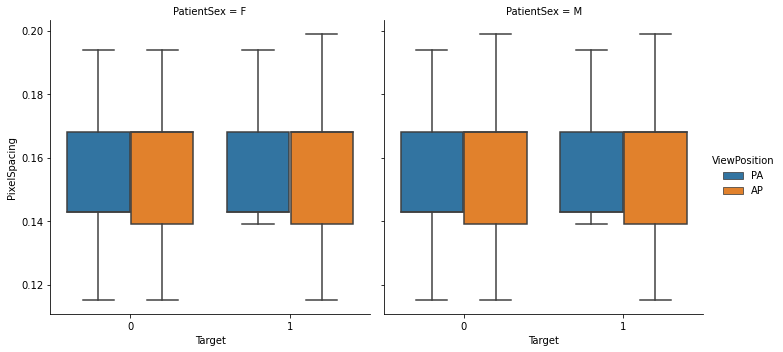

In [ ]:
plt.figure(figsize=(15,15))
sns.catplot(x="Target",
               y = "PixelSpacing",
               hue="ViewPosition", 
               col="PatientSex",
               data=train_dp, 
               kind="box");

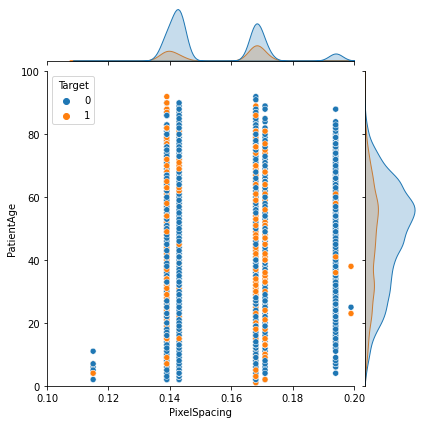

In [ ]:
sns.jointplot(x=train_dp['PixelSpacing'], y=train_dp['PatientAge'], hue=train_dp['Target'],
              kind="scatter",ylim=(0.0, 100),xlim=(0.1, 0.2));

* Patients with Pnuemonia It shows that the median average age for AP position for Male is lower compared to Female
* There are few patients whose age is much higher. Outleirs due to typo error and for the patients who doesnot have Pnuemonia
* Patients who are affected with Pnuemonia the Pixel spacing for PA has minimum starting from 0.14 where as AP position it has 0.11
* Pixel spacing for Patient age group is less than 10y for the pixel spacing around 0.12.
* Pixelspacing between 0.16 to 0.18 has larger number of patients affected with Pnuemonia 
* When the pixel spacing is large the number of cases of Pnueomia detection is lower

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

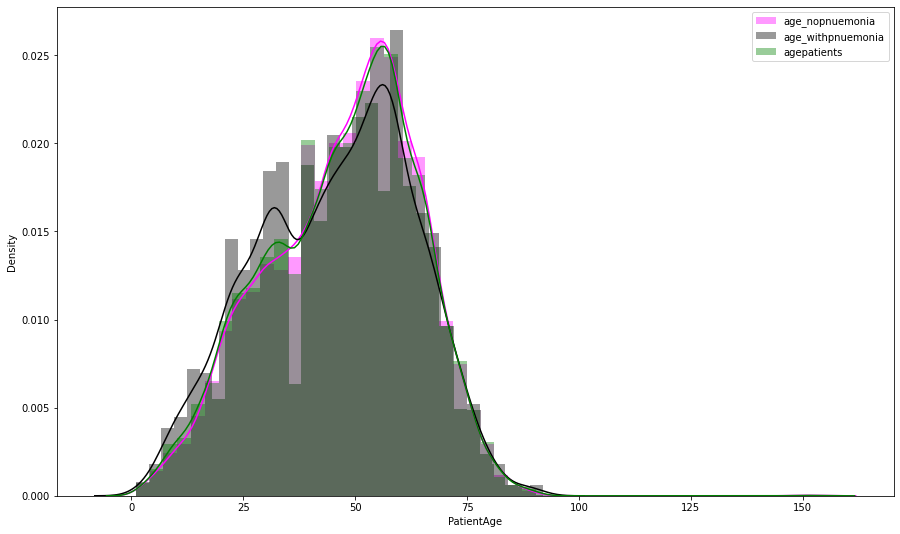

In [ ]:
age_target0 = train_dp.loc[train_dp.Target == 0, 'PatientAge']
age_target1 = train_dp.loc[train_dp.Target == 1, 'PatientAge']
age_all = train_dp['PatientAge']

f, ax = plt.subplots(figsize=(15, 9))
sns.distplot(age_target0, bins=15,color = 'magenta', label = 'age_nopnuemonia')
sns.distplot(age_target1,bins=15, color = 'black', label = 'age_withpnuemonia')
sns.distplot(age_all, bins=15,color = 'green', label = 'agepatients')
plt.legend()
plt.show()

* We can see the mostly effected patients coming for Pnuemonia check are in the age group of 50 to 60 and most number of infected patients are also in the same age group
* We can see from 30 to 40y age group are effected more with Pnuemonia

## Relation between Age and Box area

In [ ]:
train_df_target =  train_df.loc[(train_df['Target'] ==1)]

In [ ]:
train_df_age15 =  train_df_target.loc[(train_df_target['PatientAge']<=15)]

In [ ]:
train_df_age15_30 =  train_df_target.loc[(train_df_target['PatientAge'] > 15) & (train_df_target['PatientAge']<=30)]

In [ ]:
train_df_age30_50 =  train_df_target.loc[(train_df_target['PatientAge'] > 30) & (train_df_target['PatientAge']<=50)]

In [ ]:
train_df_age50_60 =  train_df_target.loc[(train_df_target['PatientAge'] > 50) & (train_df_target['PatientAge']<=60)]

In [ ]:
train_df_age60_80 =  train_df_target.loc[(train_df_target['PatientAge'] > 60) & (train_df_target['PatientAge']<=80)]

In [ ]:
train_df_age_gr80 =  train_df_target.loc[(train_df_target['PatientAge'] >= 80)]

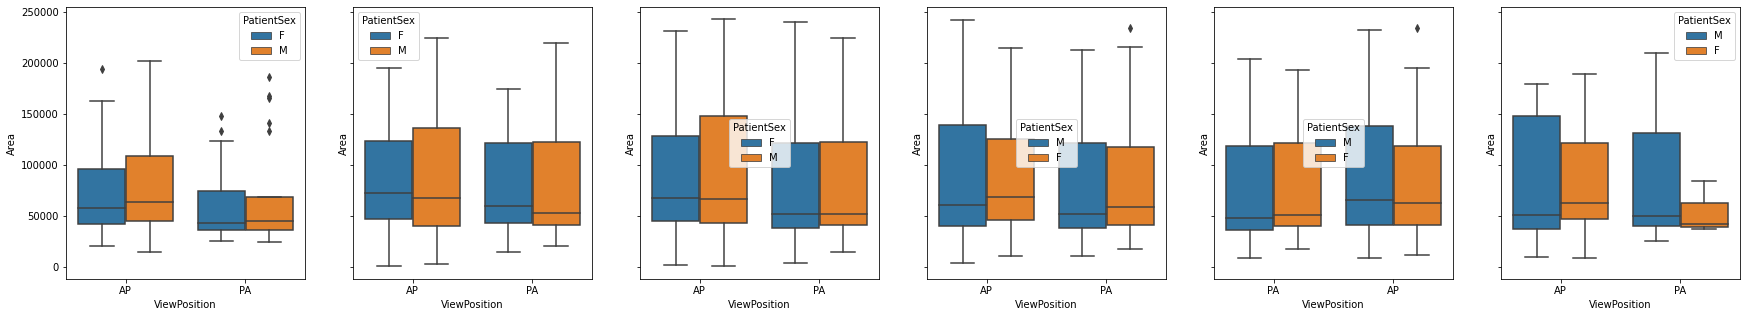

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(30, 5),sharey=True)
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age15,ax=axes[0]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age15_30,ax=axes[1]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age30_50,ax=axes[2]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age50_60,ax=axes[3]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age60_80,ax=axes[4]);
sns.boxplot(x="ViewPosition",
               y = "Area",
               hue="PatientSex", 
               data=train_df_age_gr80,ax=axes[5]);

### Relation between Box centers Vs Age Vs Pixel spacing

In [ ]:
train_df_target1 =  train_df.loc[(train_df['Target'] ==1)]

In [ ]:
train_df_age50_60 =  train_df_target1.loc[(train_df_target1['PatientAge'] > 50) & (train_df_target1['PatientAge']<60)]

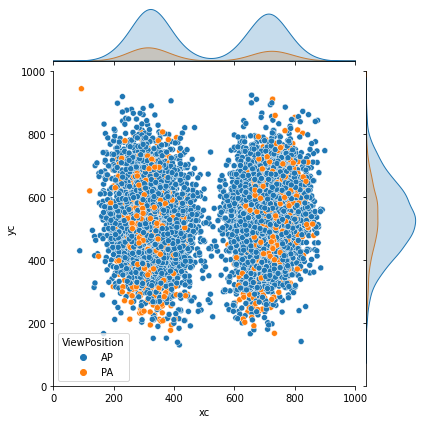

In [ ]:
#fig, axes = plt.subplots(1, 2, figsize=(15, 10))
sns.jointplot(x=train_df_target1['xc'], y=train_df_target1['yc'], hue=train_df_target1['ViewPosition'],
              kind="scatter",ylim=(0, 1000),xlim=(0, 1000));

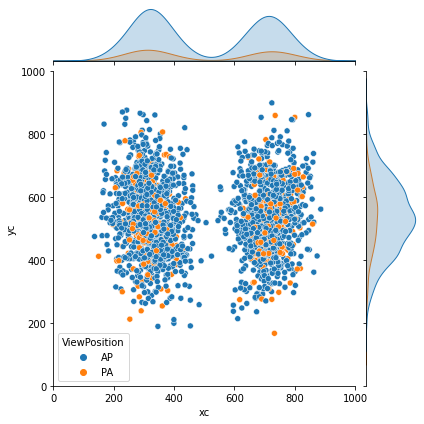

In [ ]:
sns.jointplot(x=train_df_age50_60['xc'], y=train_df_age50_60['yc'],
              kind="scatter", hue=train_df_age50_60['ViewPosition'],ylim=(0, 1000),xlim=(0, 1000));

* Patients with Box centers for PA position are mostly concentrated at the centers
* AP Position has centers all over the lungs area the detection of Pneumonia
* Few Outlier boxes are visible for the left lungs with PA position

## Comparision of Train and Test data

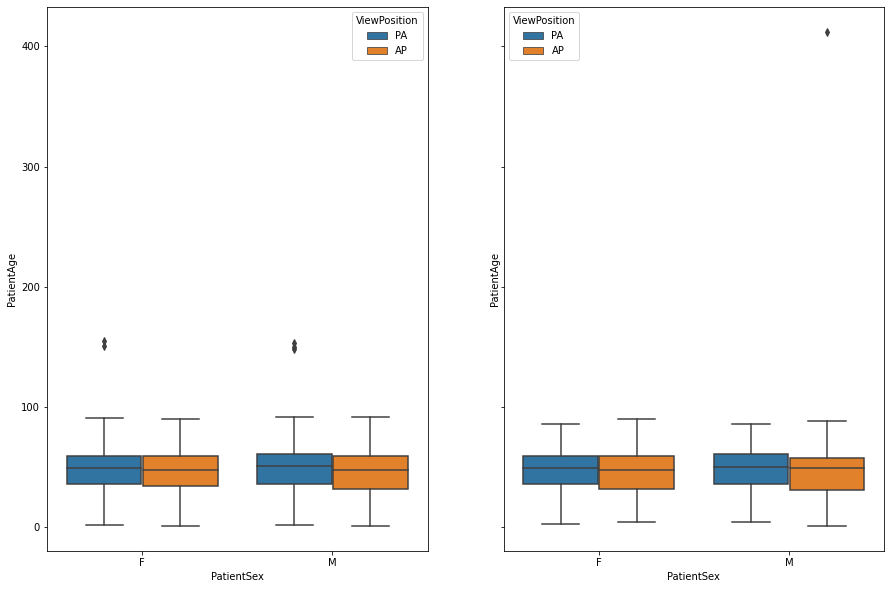

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10),sharey=True)
sns.boxplot(x="PatientSex",
               y = "PatientAge",
               hue="ViewPosition", 
               data=train_dp,ax=axes[0]);
sns.boxplot(x="PatientSex",
               y = "PatientAge",
               hue="ViewPosition", 
               data=test_df,ax=axes[1]);
               

* Train and Test data looks similar interms of number of Male and Female Patients and Age deviations
* Outliers with age > 400 is a typo error in Test data and also >120y age in Train data

In [ ]:
def remove_outliers(X_train_hr,col):
        q1 = X_train_hr[col].quantile(0.25)
        q3 = X_train_hr[col].quantile(0.75)
        IQR = q3 - q1
    
        low_whisk = q1 - 2.5 * IQR
        up_whisk = q3 + 2.5 * IQR
    
        X_train_hr.loc[(X_train_hr[col] < low_whisk) | (X_train_hr[col] > up_whisk), col] = X_train_hr[col].median()
        return X_train_hr

In [ ]:
train_dp_outlier=remove_outliers(train_dp,'PatientAge')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
test_df_outlier=remove_outliers(test_df,'PatientAge')

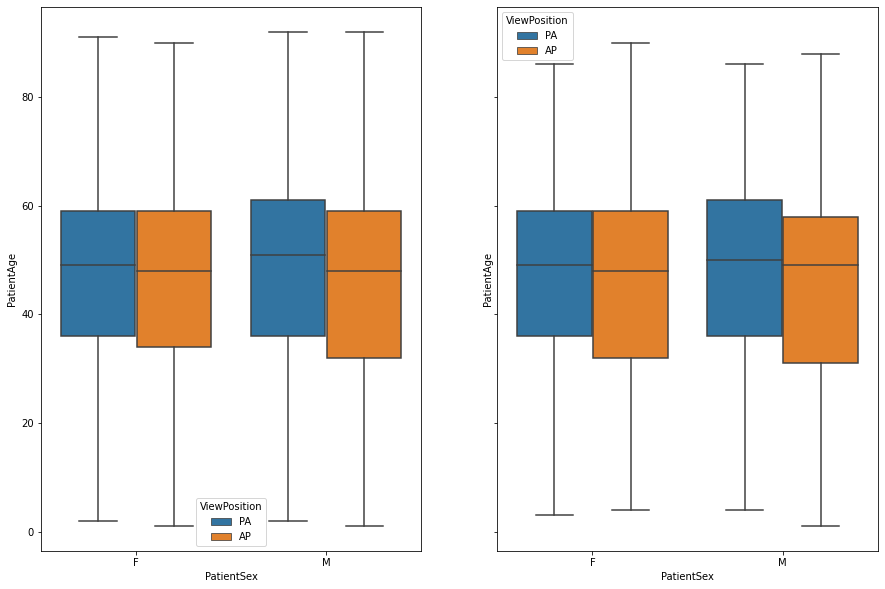

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10),sharey=True)
sns.boxplot(x="PatientSex",
               y = "PatientAge",
               hue="ViewPosition", 
               data=train_dp_outlier,ax=axes[0]);
sns.boxplot(x="PatientSex",
               y = "PatientAge",
               hue="ViewPosition", 
               data=test_df_outlier,ax=axes[1]);

### Clearly shows there is good similarity between Train and Test data.

## Checking the Images with Boxes

In [ ]:
train_df.head()

patientId      x  ...     xc     yc
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0  ...    0.0    0.0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0  ...    0.0    0.0
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0  ...    0.0    0.0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0  ...    0.0    0.0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  ...  370.5  341.5

[5 rows x 13 columns]

## Patient ID with No Pnuemonia

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
img_path='stage_2_train_images'

In [ ]:
def patient_dicom(patient):
    #fig, ax = plt.subplots(1, 1)
    plt.grid(False)
    ax = plt.gca()
    image = patient + '.dcm'
    path = os.path.join(img_path, image)
    image_dcm = dcm.read_file(path)
    ax.imshow(image_dcm.pixel_array,cmap='bone')
    ax = plt.gca()
    boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
    for box in boxes:
        x=box[0]
        y=box[1]
        w=box[2]
        h=box[3]
        ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))
        #rect=Rectangle((x, y), w, h, linewidth=2, edgecolor='r', fill=False)
        #ax.add_patch(rect)
        #plt.show()

In [ ]:
patient='0004cfab-14fd-4e49-80ba-63a80b6bddd6'

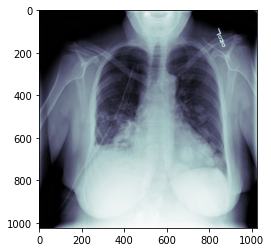

In [ ]:
patient_dicom(patient)

## Patient ID with Pnuemonia

In [ ]:
patient='00436515-870c-4b36-a041-de91049b9ab4'

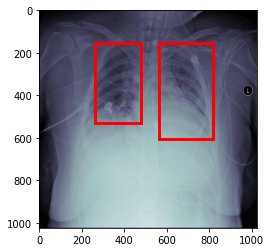

In [ ]:
patient_dicom(patient)

In [ ]:
patient='0ab261f9-4eb5-42ab-a9a5-e918904d6356'

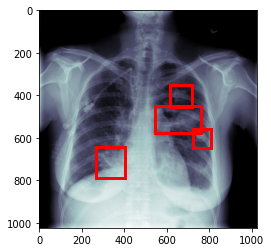

In [ ]:
patient_dicom(patient)

# Checking the images for Age group less than 15

In [ ]:
train_df_age15.head()

patientId      x      y  ...     xc     yc     Area
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0  ...  335.0  389.5  27072.0
15  00aecb01-a116-45a2-956c-08d2fa55433f  547.0  299.0  ...  606.5  381.5  65093.0
51  01be392f-a46d-4aef-a57e-9cd1a80dd47e  535.0  626.0  ...  623.5  746.0  94695.0
52  01be392f-a46d-4aef-a57e-9cd1a80dd47e  175.0  825.0  ...  259.0  879.5  29400.0
80  01fa0f5e-00c3-41cb-b5c7-10600c8633ae  602.0  438.0  ...  652.5  488.5  60802.0

[5 rows x 14 columns]

In [ ]:
def random_dcoms(number,df):
    plt.figure(figsize=(10,10))
    for i in range(number):
        plt.subplot(3, 3, i+1)
        patient= np.random.choice(df['patientId'].values)
        patient_dicom(patient)

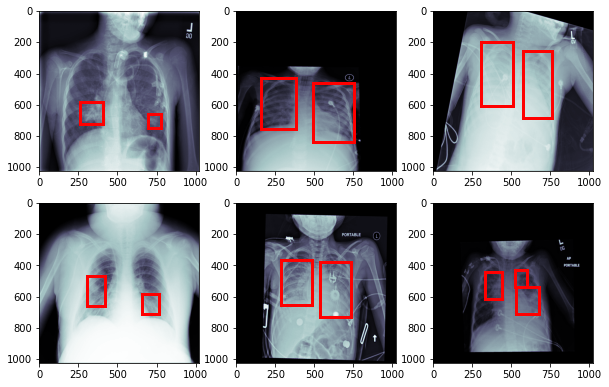

In [ ]:
random_dcoms(6,train_df_age15)

In [ ]:
train_df_target.PatientAge.value_counts()

58.0    374
56.0    294
40.0    286
52.0    259
46.0    232
       ... 
4.0       2
89.0      2
1.0       2
92.0      1
83.0      1
Name: PatientAge, Length: 92, dtype: int64

##  Patients with less than 4y

In [ ]:
train_df_age4 =  train_df_target.loc[(train_df_target['PatientAge']<=4)]

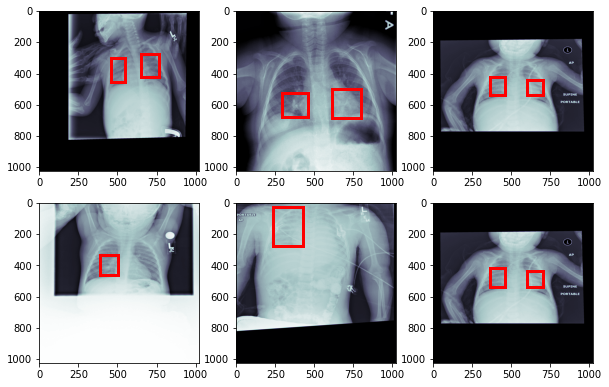

In [ ]:
random_dcoms(6,train_df_age4)

# Patients age between 50 to 60

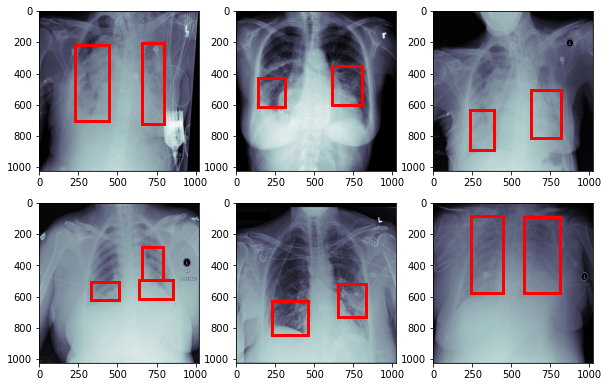

In [ ]:
random_dcoms(6,train_df_age50_60)

# Patients above 80y

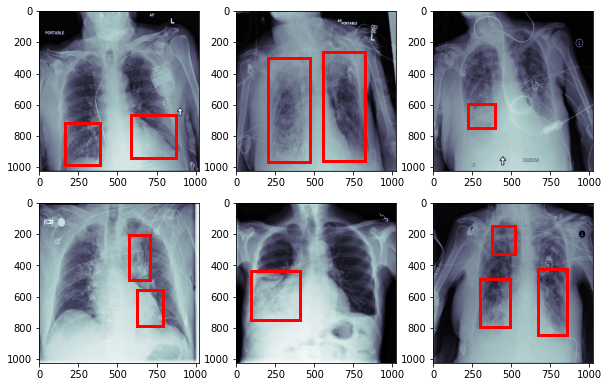

In [ ]:
random_dcoms(6,train_df_age_gr80)

# Image Normalization using Histrogram/CLACHE

### Pixel distribution

In [ ]:
def random_histograms(number,df):
    plt.figure(figsize=(10,5))
    for i in range(number):
        patient= np.random.choice(df['patientId'].values)
        #pixeldistribution(patient)
        image = patient + '.dcm'
        path = os.path.join(img_path, image)
        image_dcm = dcm.read_file(path)
      #sns.distplot(image_dcm.ravel())
        image_dcm = image_dcm.pixel_array
        n_bins = 30
        plt.subplot(1, 2, i+1)
        plt.hist(image_dcm.flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
        plt.subplot(1, 2, i+2)
        plt.imshow(image_dcm,cmap='bone')
        plt.grid(False)
        ax = plt.gca()
        boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
        for box in boxes:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

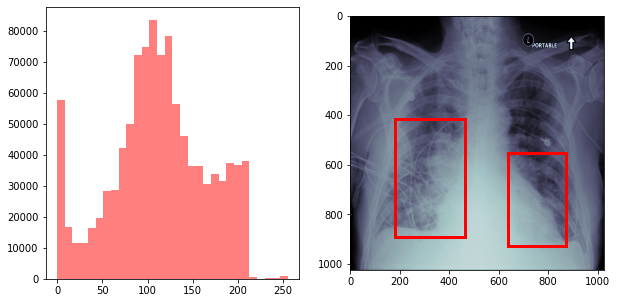

In [ ]:
random_histograms(1,train_df_age_gr80)

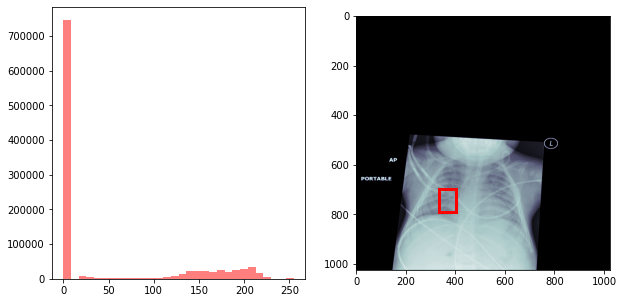

In [ ]:
random_histograms(1,train_df_age4)

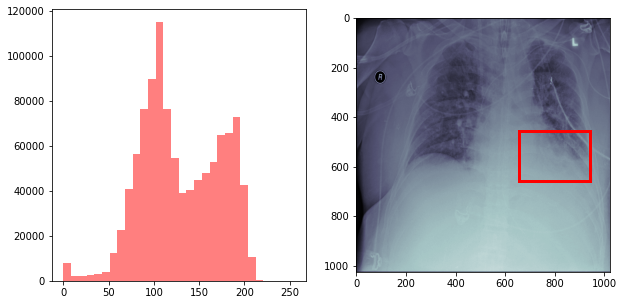

In [ ]:
random_histograms(1,train_df_age50_60)

In [ ]:
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure

In [ ]:
patient='0ab261f9-4eb5-42ab-a9a5-e918904d6356'

## without Normalization

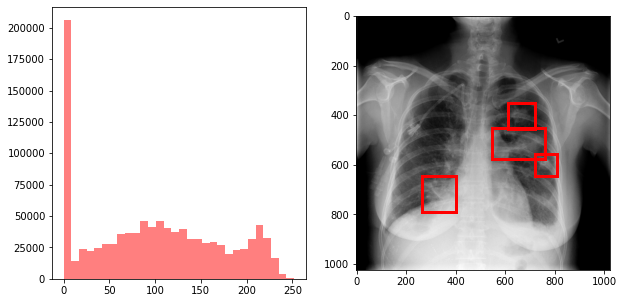

In [ ]:
image = patient + '.dcm'
path = os.path.join(img_path, image)
image_dcm = dcm.read_file(path)
image_dcm = image_dcm.pixel_array
img = image_dcm
n_bins = 30
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.grid(False)
ax = plt.gca()
boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
for box in boxes:
    x=box[0]
    y=box[1]
    w=box[2]
    h=box[3]
    ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

## Histogram Normalized

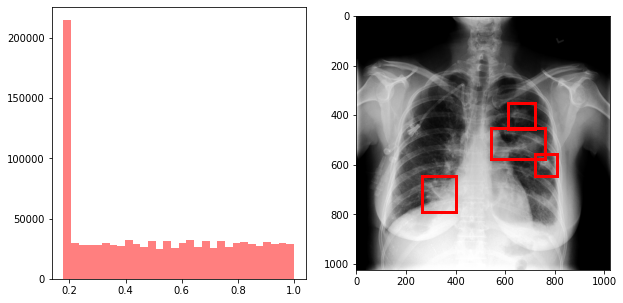

In [ ]:
image = patient + '.dcm'
path = os.path.join(img_path, image)
image_dcm = dcm.read_file(path)
image_dcm = image_dcm.pixel_array
img = exposure.equalize_hist(image_dcm)
n_bins = 30
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.grid(False)
ax = plt.gca()
boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
for box in boxes:
    x=box[0]
    y=box[1]
    w=box[2]
    h=box[3]
    ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

## CLACHE Normalized
* Produces sharper images ( Bone Enhanced View) 

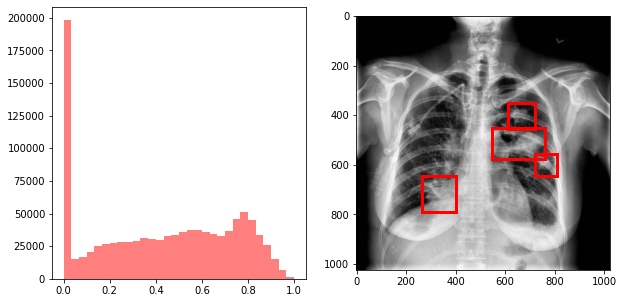

In [ ]:
image = patient + '.dcm'
path = os.path.join(img_path, image)
image_dcm = dcm.read_file(path)
image_dcm = image_dcm.pixel_array
img = exposure.equalize_adapthist(image_dcm/np.max(image_dcm))
n_bins = 30
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(img.flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.grid(False)
ax = plt.gca()
boxes=train_df[['x','y','width','height']][train_df['patientId']==patient].values
for box in boxes:
    x=box[0]
    y=box[1]
    w=box[2]
    h=box[3]
    ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

### Conclusion is the detection of white spots is much more clear with CLACHE Normalization

# Model - Predicting Mask using AutoEncoder-UNet

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 16 06:33:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os; os.chdir('/content/drive/MyDrive/Capstone')

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
!pip install pydicom
import pydicom as dicom
import cv2
import os
from google.colab.patches import cv2_imshow
import csv
import keras

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 2.0 MB 7.8 MB/s 


In [ ]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.metrics import MeanIoU
from tensorflow.keras import layers
from keras.callbacks import CSVLogger
import datetime
import pydicom as dicom

In [ ]:
keras = tf.compat.v1.keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import seaborn as sns
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure

### Convert images to Jpeg

In [ ]:
import cv2
import os
folder_path = 'stage_2_train_images'
jpg_path = "image_jpeg"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_path, image), pixel_array_numpy)

### Convert images to Jpeg- Clache Normalize

In [ ]:
import cv2
import os
folder_path = 'stage_2_train_images'
jpg_path = "image_clache"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    image_dcm = dicom.dcmread(os.path.join(folder_path, image))
    image_dcm = image_dcm.pixel_array
    image_dcm = exposure.equalize_adapthist(image_dcm/np.max(image_dcm))
    image_dcm = 255*image_dcm
    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_path, image), image_dcm)

### Convert images to Jpeg- Histogram Normalize

In [ ]:
import cv2
import os
folder_path = 'stage_2_train_images'
jpg_path = "image_hist"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    image_dcm = dicom.dcmread(os.path.join(folder_path, image))
    image_dcm = image_dcm.pixel_array
    image_dcm = exposure.equalize_hist(image_dcm)
    image_dcm = 255*image_dcm
    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_path, image), image_dcm)

In [ ]:
folder = 'image_clache'
filenames = os.listdir(folder)
print('Number of Train images:', len(filenames))

Number of Train images: 26684


### Creating Masks

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import csv
import os

mask_path = "/content/drive/MyDrive/Capstone/masks/"
csv_path = "/content/drive/MyDrive/Capstone/stage_2_train_labels.csv"

sheet = open(csv_path, newline='')

images_path = os.listdir("/content/drive/MyDrive/Capstone/image_jpeg")
images_path = [os.path.splitext(x)[0] for x in images_path]
images_path = [x.strip() for x in images_path]
i=1
for image_name in images_path: 
    sheet = open(csv_path, newline='')
    reader = csv.reader(sheet)
    for row in reader:
      if row[0]==image_name:
        print(image_name)
        print(i)
        i+=1
        if row[5]=='1':
          pt1 = (int(row[1].split('.')[0]),int(row[2].split('.')[0]))
          pt2 = int(row[1].split('.')[0])+int(row[3].split('.')[0]),int(row[2].split('.')[0])+int(row[4].split('.')[0])

          if os.path.isfile(mask_path+image_name+'.jpg')==True:       
            img = cv2.imread(mask_path+image_name+'.jpg')
          else:
            img = np.zeros((1024, 1024, 3), dtype = "uint8")
          cv2.rectangle(img, pt1, pt2, (255,255,255), -1)
          cv2.imwrite(mask_path+image_name+'.jpg', img)  
          #cv2_imshow(img)
        else:  
          img = np.zeros((1024, 1024, 3), dtype = "uint8")
          cv2.imwrite(mask_path+row[0]+'.jpg', img)
    sheet.close()

In [ ]:
folder = 'masks'
filenames = os.listdir(folder)
print('Number of Train images:', len(filenames))

Number of Train images: 26684


In [ ]:
folder = 'image_jpeg'
filenames = os.listdir(folder)
print('Number of Train images:', len(filenames))

Number of Train images: 26684


## DataFrame with image data attributes

In [ ]:
images_df = pd.read_pickle('images_train_df.pkl')

In [ ]:
train_df = images_df.copy()

In [ ]:
train_df['x'] = train_df['x'].fillna(0)
train_df['y'] = train_df['y'].fillna(0)
train_df['width'] = train_df['width'].fillna(0)
train_df['height'] = train_df['height'].fillna(0)

In [ ]:
train_df['xc'] = train_df['x'] + train_df['width']/2
train_df['yc'] = train_df['y'] + train_df['height']/2

In [ ]:
train_df['Area'] = train_df['height']*train_df['width']

In [ ]:
train_df=train_df.drop(['Rows','Columns'],axis=1)

In [ ]:
train_df.shape

(30227, 14)

In [ ]:
train_dp = train_df.drop_duplicates(subset=['patientId'])

## Train validation split

In [ ]:
idx = np.random.rand(len(train_dp)) < 0.8
val_df = train_dp[~idx]
train_df = train_dp[idx]
val_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

In [ ]:
#train_df.to_csv('train_df.csv', index=False)
#val_df.to_csv('val_df.csv', index=False)

In [ ]:
train_df = pd.read_csv('train_df.csv')
val_df=pd.read_csv('val_df.csv')

### Downsample - Train images

In [ ]:
train_dp_1 =  train_dp.loc[(train_dp['Target'] ==1)]

In [ ]:
train_dp_0 =  train_dp.loc[(train_dp['Target'] ==0)]

In [ ]:
idx = np.random.rand(len(train_dp_0)) < 0.3
train_dp_0 = train_dp_0[idx]

In [ ]:
train_dp_0.shape

(6205, 14)

In [ ]:
train_dp_1.shape

(6012, 14)

In [ ]:
train_dp_downsample=pd.concat([train_dp_0,train_dp_1],axis=0)

In [ ]:
from sklearn.utils import shuffle
train_dp_downsample = shuffle(train_dp_downsample)

In [ ]:
train_dp_downsample.shape

(12217, 14)

In [ ]:
idx = np.random.rand(len(train_dp_downsample)) < 0.8
val_df = train_dp_downsample[~idx]
train_df = train_dp_downsample[idx]
val_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

In [ ]:
train_df.shape, val_df.shape

((9791, 15), (2426, 15))

In [ ]:
train_df.to_csv('train_df-downsample.csv', index=False)
val_df.to_csv('val_df-downsample.csv', index=False)

In [ ]:
train_df = pd.read_csv('train_df-downsample.csv')
val_df=pd.read_csv('val_df-downsample.csv')

### Checking Image and Masks

In [ ]:
base_size=1024

In [ ]:
def display_image_mask(img_num, df,path):

    #Create a pyplot with two images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))

    #Read  image and corresponding mask
    img = tf.keras.preprocessing.image.load_img(path+'/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')

    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')
    
    patient=df.loc[img_num, 'patientId']
    #Show both images
    ax1.set_title(path)
    ax1.imshow(img, cmap = 'gray', interpolation = 'bilinear')
    ax1.axis('on')
  
    ax2.set_title('Mask')
    ax2.imshow(mask_img, cmap = 'gray', interpolation = 'bilinear')
    ax2.axis('on')
    plt.show()

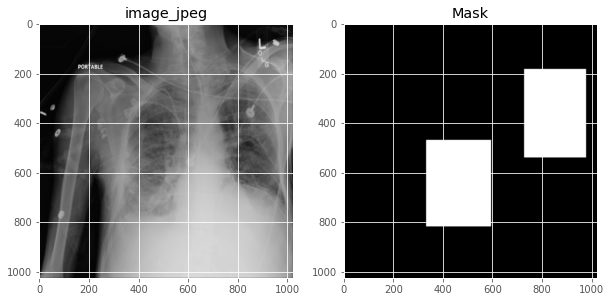

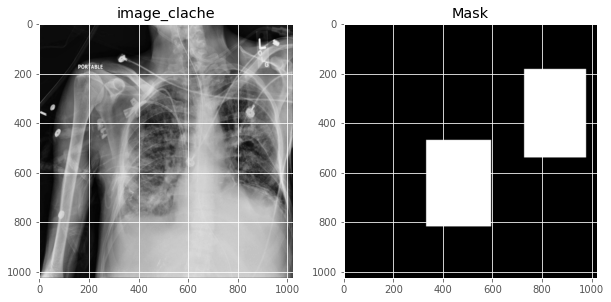

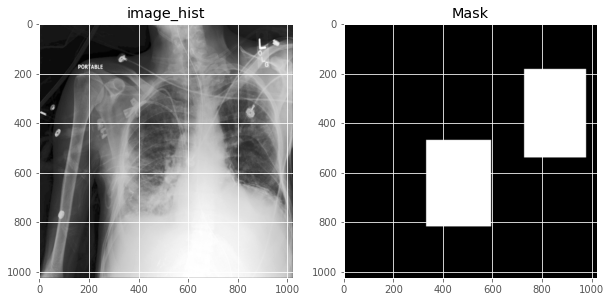

In [ ]:
img_num = np.random.randint(0, train_df.shape[0])
display_image_mask(img_num, train_df,'image_jpeg')
display_image_mask(img_num, train_df,'image_clache')
display_image_mask(img_num, train_df,'image_hist')

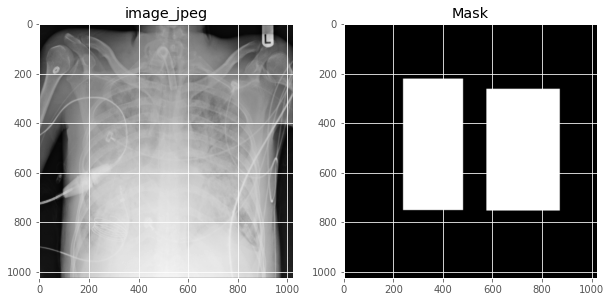

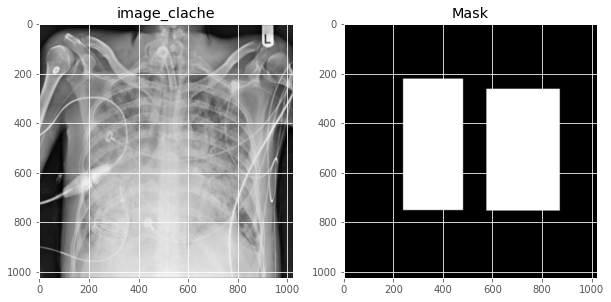

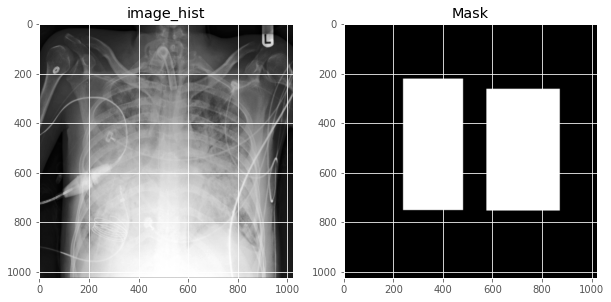

In [ ]:
img_num = np.random.randint(0, train_df.shape[0])
display_image_mask(img_num, train_df,'image_jpeg')
display_image_mask(img_num, train_df,'image_clache')
display_image_mask(img_num, train_df,'image_hist')

### Batch generator - 

In [ ]:
img_size = 128
num_classes = 2

In [ ]:
def batch_generator(path,df, batch_size=32):

    while True:

        #Create random indexes
        idx = np.random.randint(0, df.shape[0], batch_size)

        #Initialize numpy arrays for X and y
        #Input image is size img_size,img_size,1
        #X = np.zeros((batch_size, img_size, img_size,3))
        X = np.zeros((batch_size, img_size, img_size, 1), dtype=np.float32)
        #Mask's size is img_size, img_size, 1
        y = np.zeros((batch_size, img_size, img_size,num_classes))
        #y = np.zeros((batch_size, img_size, img_size,1))

        #Populate X and y with actual data
        for i in range(len(idx)):

            #Read image
            img = tf.keras.preprocessing.image.load_img(path+'/' + df.loc[idx[i],'patientId'] + '.jpg', color_mode='grayscale',
                                                        target_size=(img_size, img_size))
            img = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')/255.0

            X[i] = img

            #Read mask
            mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[idx[i],'patientId'] + '.jpg',
                                                            color_mode = 'grayscale',
                                                            target_size=(img_size, img_size))
            mask_img = tf.keras.preprocessing.image.img_to_array(mask_img).astype('uint8')/255.0
            mask_img = tf.keras.utils.to_categorical(mask_img, num_classes=num_classes)

            y[i] = mask_img

        yield X, y

In [ ]:
a = batch_generator('image_clache',train_df, batch_size=2)
x, y = next(a)

In [ ]:
x.shape

(2, 128, 128, 1)

In [ ]:
 y.shape

(2, 128, 128, 2)

In [ ]:
np.unique(y[0])

array([0., 1.])

## 1.  Building UNET ( Encoder with 2 Layers of CNN)      


In [ ]:
def conv2d_block(input_tensor, n_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [ ]:
def build_unet(input_img, n_filters=16, dropout=0.1):

    #ENCODER - DOWNSAMPLE the image - 128x128x1

    #First Block
    c1 = conv2d_block(input_img, n_filters*1) #128x128x16
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) #64x64x16
    p1 = tf.keras.layers.Dropout(dropout)(p1) #64x64x16
    #output will be 64x64x16 for image size 128x128x1

    #Second Block
    c2 = conv2d_block(p1, n_filters*2) #64x64x32
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) #32x32x32
    p2 = tf.keras.layers.Dropout(dropout)(p2)
    #output will be 32x32x32

    #Third Block
    c3 = conv2d_block(p2, n_filters*4) #32x32x64
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3) #16x16x64
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    #output will be 16x16x64

    #Fourth Block
    c4 = conv2d_block(p3, n_filters*8) #16x16x128
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)
    ##output will be 8x8x128 

    #Fifth Block
    c5 = conv2d_block(p4, n_filters*16)
    #output will be 8x8x256

    #We now have output of Encoder

    #DECODER - UPSAMPLE the feature to generate mask

    #First Block - connected to fourth block on DOWNSAMPLE side
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), 
                                         strides = (2, 2), 
                                         padding = 'same')(c5) #16x16x128
    #Skip connection
    u6 = tf.keras.layers.concatenate([u6, c4]) #16x16x256
    u6 = tf.keras.layers.Dropout(dropout)(u6) 
    c6 = conv2d_block(u6, n_filters * 8) #16x16x128

    #Second Block - connected to third block on DOWNSAMPLE side
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6) #32x32x64
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4)

    #Third Block - connected to second block on DOWNSAMPLE side
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7) #64x64x32
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2) 

    #Fourth Block - connected to first block on DOWNSAMPLE side
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8) #128x128x16
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1) #128 x 128 x 16

    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9) #128x128x2

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
#Clear out notebook session
tf.keras.backend.clear_session()

#Define input layer
input_img = tf.keras.layers.Input((img_size, img_size, 1), name='input_img')

#Build model
model = build_unet(input_img, dropout=.3)

#Compile model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_img[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-jqrkslcg
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-jqrkslcg
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 4.6 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=d379dc6c9dd4e3d9d38562c2c0366c7f2793046703f6fb2901a470d4cbd94011
  Stored in directory: /tmp/pip-ephem-wheel-cache-2p1ptpx7/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
import segmentation_models as sm
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

Segmentation Models: using `keras` framework.


In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_nonorm = [
    keras.callbacks.ModelCheckpoint('Mask_No_Normalization-2layerEncoder.h5', save_weights_only=True,mode="max", save_best_only=True,
                                    monitor='val_f1-score',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_f1-score", factor=0.2, patience=5, min_lr=1e-4, verbose=1, mode="max")
]

### Train and Validation generator 
- No Normalize
-Clache Normalize
-Histogram Normalize

In [ ]:
train_generator = batch_generator('image_jpeg',train_df,batch_size=96)
val_generator = batch_generator('image_jpeg',val_df, batch_size=32)

In [ ]:
train_generator_clache = batch_generator('image_clache',train_df,batch_size=96)
val_generator_clache = batch_generator('image_clache',val_df, batch_size=32)

In [ ]:
train_generator_hist = batch_generator('image_hist',train_df,batch_size=96)
val_generator_hist = batch_generator('image_hist',val_df, batch_size=32)

### Training- No Normalization

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//96, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//32, 
          callbacks=[callbacks],
          epochs=20)

Epoch 1/15
222/222 [==============================] - ETA: 0s - loss: 0.5389 - iou_score: 0.5178 - f1-score: 0.5813 
Epoch 1: val_f1-score improved from inf to 0.34439, saving model to Mask_No_Normalization-2layerEncoder.h5
222/222 [==============================] - 8712s 39s/step - loss: 0.5389 - iou_score: 0.5178 - f1-score: 0.5813 - val_loss: 0.9581 - val_iou_score: 0.2393 - val_f1-score: 0.3444 - lr: 1.0000e-04
Epoch 2/15
222/222 [==============================] - ETA: 0s - loss: 0.4686 - iou_score: 0.5805 - f1-score: 0.6639 
Epoch 2: val_f1-score did not improve from 0.34439
222/222 [==============================] - 3487s 16s/step - loss: 0.4686 - iou_score: 0.5805 - f1-score: 0.6639 - val_loss: 0.6521 - val_iou_score: 0.3915 - val_f1-score: 0.4852 - lr: 1.0000e-04
Epoch 3/15
222/222 [==============================] - ETA: 0s - loss: 0.4318 - iou_score: 0.5948 - f1-score: 0.6797
Epoch 3: val_f1-score did not improve from 0.34439
222/222 [==============================] - 1644s 7s

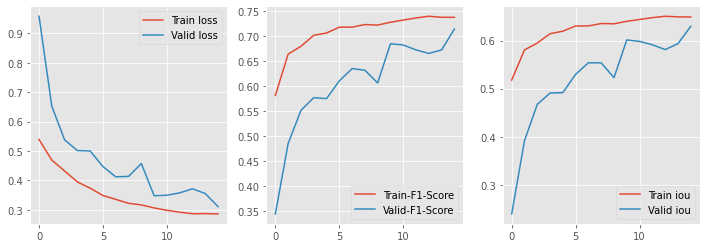

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

## Training on Down sample Images

In [ ]:
valbatch = 32
trainbatch=64

In [ ]:
train_generator = batch_generator('image_jpeg',train_df,batch_size=trainbatch)
val_generator = batch_generator('image_jpeg',val_df, batch_size=valbatch)

In [ ]:
train_generator_clache = batch_generator('image_clache',train_df,batch_size=trainbatch)
val_generator_clache = batch_generator('image_clache',val_df, batch_size=valbatch)

In [ ]:
train_generator_hist = batch_generator('image_hist',train_df,batch_size=trainbatch)
val_generator_hist = batch_generator('image_hist',val_df, batch_size=valbatch)

### Training- No Normalization

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_nonorm = [
    keras.callbacks.ModelCheckpoint('Mask_No_Normalization-2layerEncoder.h5', save_weights_only=True,mode="max", save_best_only=True,
                                    monitor='val_f1-score',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_f1-score", factor=0.2, patience=5, min_lr=1e-4, verbose=1, mode="max")
]

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_nonorm],
          epochs=30)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.5991 - iou_score: 0.3911 - f1-score: 0.4653 
Epoch 1: val_f1-score improved from -inf to 0.45624, saving model to Mask_No_Normalization-2layerEncoder.h5
152/152 [==============================] - 7866s 52s/step - loss: 0.5991 - iou_score: 0.3911 - f1-score: 0.4653 - val_loss: 0.7768 - val_iou_score: 0.3516 - val_f1-score: 0.4562 - lr: 1.0000e-04
Epoch 2/30
152/152 [==============================] - ETA: 0s - loss: 0.4883 - iou_score: 0.5894 - f1-score: 0.6820 
Epoch 2: val_f1-score improved from 0.45624 to 0.61594, saving model to Mask_No_Normalization-2layerEncoder.h5
152/152 [==============================] - 3022s 20s/step - loss: 0.4883 - iou_score: 0.5894 - f1-score: 0.6820 - val_loss: 0.5678 - val_iou_score: 0.5065 - val_f1-score: 0.6159 - lr: 1.0000e-04
Epoch 3/30
152/152 [==============================] - ETA: 0s - loss: 0.4259 - iou_score: 0.6247 - f1-score: 0.7258
Epoch 3: val_f1-score improved from 0.615

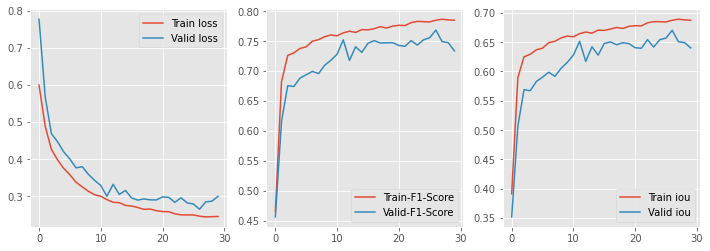

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

### Training- Clache Normaization

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_clache = [
    keras.callbacks.ModelCheckpoint('Mask_Clache_Normalization-2layerEncoder-start.h5', save_weights_only=True,mode="max", save_best_only=True,
                                    monitor='val_f1-score',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_f1-score", factor=0.2, patience=5, min_lr=1e-4, verbose=1, mode="max")
]

In [ ]:
history = model.fit(train_generator_clache,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator_clache, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_clache],
          epochs=30)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.4915 - iou_score: 0.5170 - f1-score: 0.6090
Epoch 1: val_f1-score improved from -inf to 0.38234, saving model to Mask_Clache_Normalization-2layerEncoder-start.h5
152/152 [==============================] - 302s 2s/step - loss: 0.4915 - iou_score: 0.5170 - f1-score: 0.6090 - val_loss: 1.3776 - val_iou_score: 0.2581 - val_f1-score: 0.3823 - lr: 1.0000e-04
Epoch 2/30
152/152 [==============================] - ETA: 0s - loss: 0.3910 - iou_score: 0.6139 - f1-score: 0.7147
Epoch 2: val_f1-score improved from 0.38234 to 0.62945, saving model to Mask_Clache_Normalization-2layerEncoder-start.h5
152/152 [==============================] - 289s 2s/step - loss: 0.3910 - iou_score: 0.6139 - f1-score: 0.7147 - val_loss: 0.5106 - val_iou_score: 0.5207 - val_f1-score: 0.6294 - lr: 1.0000e-04
Epoch 3/30
152/152 [==============================] - ETA: 0s - loss: 0.3460 - iou_score: 0.6390 - f1-score: 0.7393
Epoch 3: val_f1-score impro

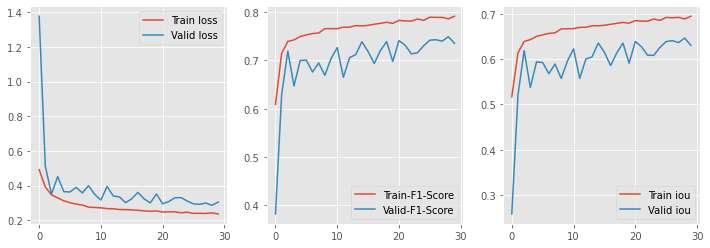

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

### Training- Histogram Normalization

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_hist = [
    keras.callbacks.ModelCheckpoint('Mask_histogram_Normalization-2layerEncoder.h5',mode="max", save_best_only=True,
                                    monitor='val_f1-score',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_f1-score", factor=0.2, patience=5, min_lr=1e-4, verbose=1, mode="max")
]

In [ ]:
history = model.fit(train_generator_hist,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator_hist, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_hist],
          epochs=30)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.5850 - iou_score: 0.4294 - f1-score: 0.5315 
Epoch 1: val_f1-score improved from -inf to 0.27035, saving model to Mask_histogram_Normalization-2layerEncoder.h5
152/152 [==============================] - 5243s 35s/step - loss: 0.5850 - iou_score: 0.4294 - f1-score: 0.5315 - val_loss: 0.8655 - val_iou_score: 0.1627 - val_f1-score: 0.2703 - lr: 1.0000e-04
Epoch 2/30
152/152 [==============================] - ETA: 0s - loss: 0.4972 - iou_score: 0.5861 - f1-score: 0.6891 
Epoch 2: val_f1-score improved from 0.27035 to 0.40864, saving model to Mask_histogram_Normalization-2layerEncoder.h5
152/152 [==============================] - 2093s 14s/step - loss: 0.4972 - iou_score: 0.5861 - f1-score: 0.6891 - val_loss: 0.8519 - val_iou_score: 0.2817 - val_f1-score: 0.4086 - lr: 1.0000e-04
Epoch 3/30
152/152 [==============================] - ETA: 0s - loss: 0.4507 - iou_score: 0.6170 - f1-score: 0.7205
Epoch 3: val_f1-score impro

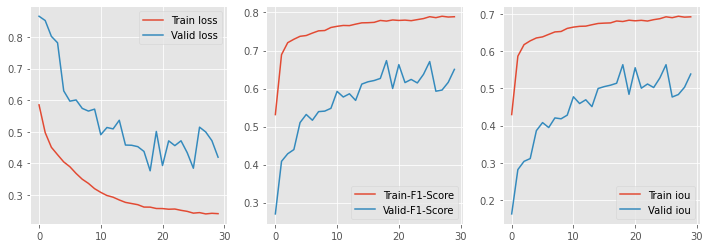

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

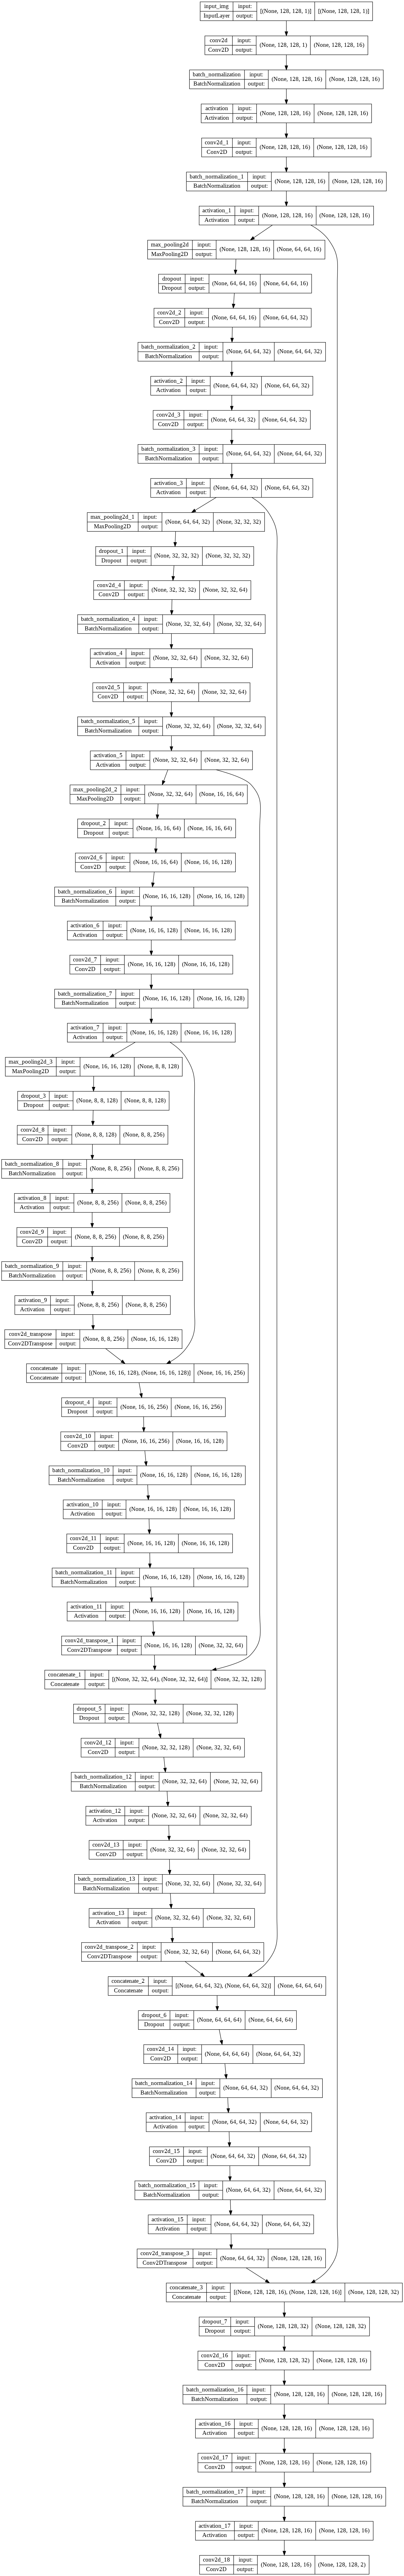

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True,expand_nested=True, show_layer_names=True)

# Predict the Masks

In [ ]:
def mask_prediction(path,weights,img_num, df):

    #Read image and corresponding mask
    img = tf.keras.preprocessing.image.load_img(path +'/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')
    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')

    #Model prediction
    test_img = img.resize((img_size, img_size))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
    test_img = np.expand_dims(test_img, axis=0) #1,128,128,1

    model.load_weights(weights)

    pred = model.predict(test_img) #1,128,128,num_classes
    
    predicted_classes = np.argmax(pred[0], axis=-1)
    
    #Create a pyplot with two images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))

    #Show both images
    ax1.set_title(path)
    ax1.imshow(img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Actual Mask')
    ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax3.set_title('Predicted Mask'+' of '+path)
    ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


    plt.show()

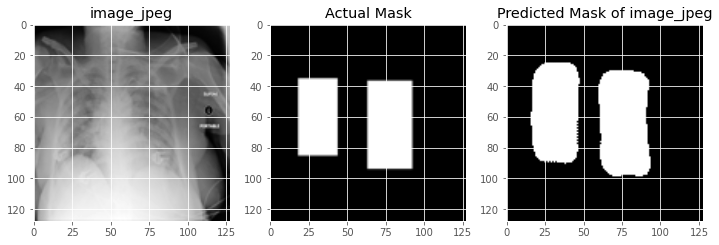

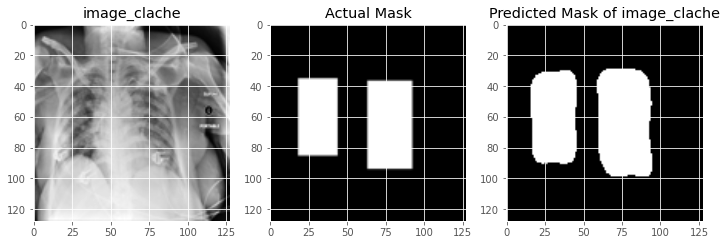

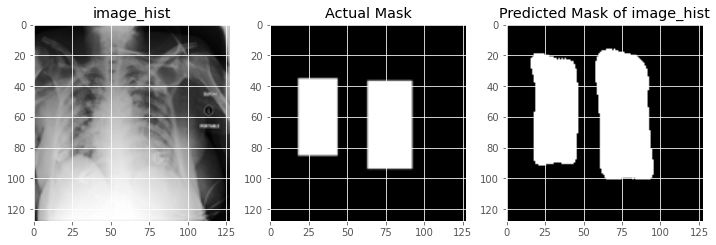

In [ ]:
img_num = np.random.randint(0, val_df.shape[0])
mask_prediction('image_jpeg','Mask_No_Normalization-2layerEncoder.h5',img_num, val_df)
mask_prediction('image_clache','Mask_Clache_Normalization-2layerEncoder-start.h5',img_num, val_df)
mask_prediction('image_hist','Mask_histogram_Normalization-2layerEncoder.h5',img_num, val_df)

# Random Prediction of Masks

In [ ]:
def random_predictions(number,df):
    i=0
    plt.figure(figsize=(10,10))
    for i in range(number):
        #plt.subplot(3, 3, i+1)
        img_num = np.random.randint(0, val_df.shape[0])
        mask_prediction('image_jpeg','Mask_No_Normalization-2layerEncoder.h5',img_num, df)
        mask_prediction('image_clache','Mask_Clache_Normalization-2layerEncoder-start.h5',img_num, df)
        mask_prediction('image_hist','Mask_histogram_Normalization-2layerEncoder.h5',img_num, df)

<Figure size 720x720 with 0 Axes>

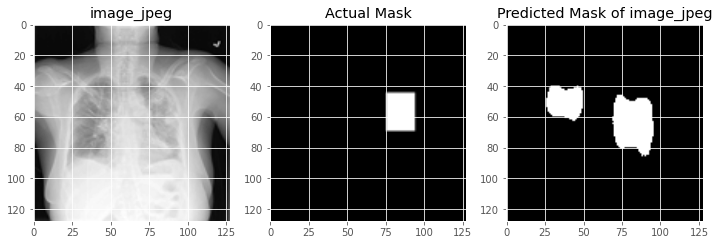

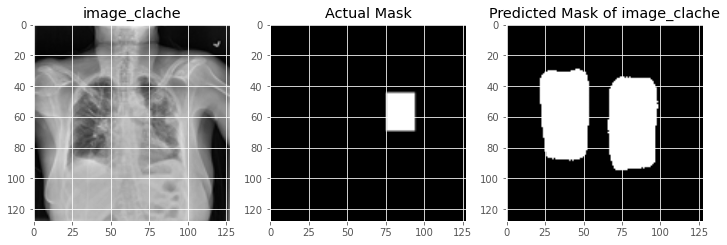

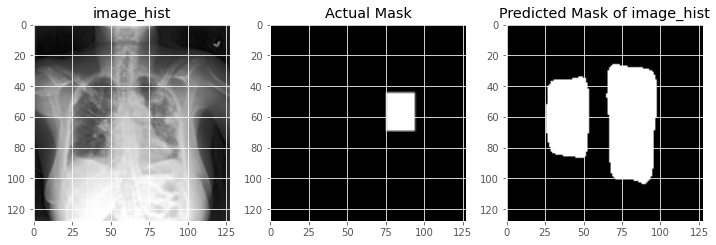

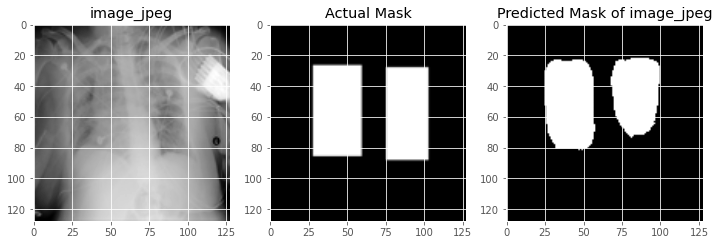

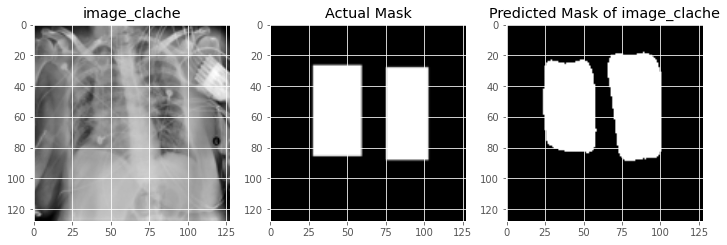

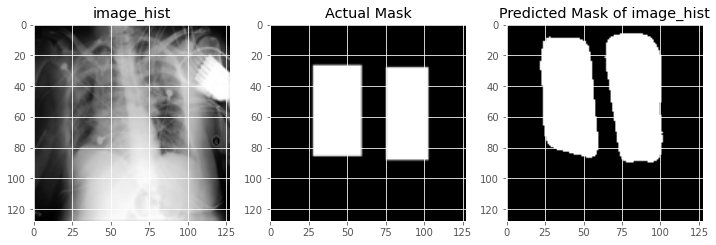

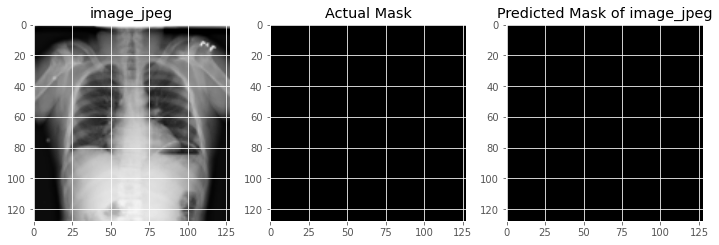

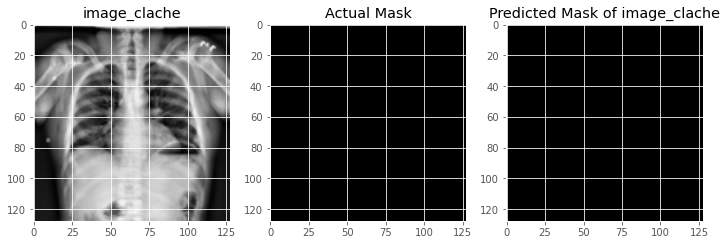

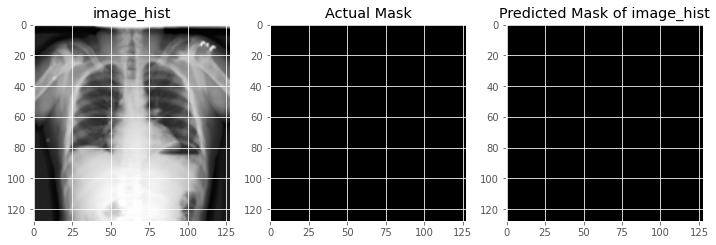

In [ ]:
random_predictions(3,val_df)

# Model Unet - 3 CNN Layers- Filters 24,Dropout 20%, Imagesize 224

In [ ]:
img_size = 224
num_classes = 2

In [ ]:
def conv2d_block(input_tensor, n_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

        # Third layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [ ]:
def build_unet(input_img, n_filters=24, dropout=0.1):

    #ENCODER - DOWNSAMPLE the image - 128x128x1

    #First Block
    c1 = conv2d_block(input_img, n_filters*1) #128x128x16
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) #64x64x16
    p1 = tf.keras.layers.Dropout(dropout)(p1) #64x64x16
    #output will be 64x64x16 for image size 128x128x1

    #Second Block
    c2 = conv2d_block(p1, n_filters*2) #64x64x32
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) #32x32x32
    p2 = tf.keras.layers.Dropout(dropout)(p2)
    #output will be 32x32x32

    #Third Block
    c3 = conv2d_block(p2, n_filters*4) #32x32x64
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3) #16x16x64
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    #output will be 16x16x64

    #Fourth Block
    c4 = conv2d_block(p3, n_filters*8) #16x16x128
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)
    ##output will be 8x8x128 

    #Fifth Block
    c5 = conv2d_block(p4, n_filters*16)
    #output will be 8x8x256

    #We now have output of Encoder

    #DECODER - UPSAMPLE the feature to generate mask

    #First Block - connected to fourth block on DOWNSAMPLE side
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), 
                                         strides = (2, 2), 
                                         padding = 'same')(c5) #16x16x128
    #Skip connection
    u6 = tf.keras.layers.concatenate([u6, c4]) #16x16x256
    u6 = tf.keras.layers.Dropout(dropout)(u6) 
    c6 = conv2d_block(u6, n_filters * 8) #16x16x128

    #Second Block - connected to third block on DOWNSAMPLE side
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6) #32x32x64
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4)

    #Third Block - connected to second block on DOWNSAMPLE side
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7) #64x64x32
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2) 

    #Fourth Block - connected to first block on DOWNSAMPLE side
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8) #128x128x16
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1) #128 x 128 x 16

    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9) #128x128x2

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
#Clear out notebook session
tf.keras.backend.clear_session()

#Define input layer
input_img = tf.keras.layers.Input((img_size, img_size, 1), name='input_img')

#Build model
model1 = build_unet(input_img, dropout=.2)

#Compile model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 24  240         ['input_img[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 24  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import segmentation_models as sm
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics)

Segmentation Models: using `keras` framework.


In [ ]:
valbatch = 32
trainbatch=64

In [ ]:
train_generator = batch_generator('image_jpeg',train_df,batch_size=trainbatch)
val_generator = batch_generator('image_jpeg',val_df, batch_size=valbatch)

In [ ]:
train_generator_clache = batch_generator('image_clache',train_df,batch_size=trainbatch)
val_generator_clache = batch_generator('image_clache',val_df, batch_size=valbatch)

In [ ]:
train_generator_hist = batch_generator('image_hist',train_df,batch_size=trainbatch)
val_generator_hist = batch_generator('image_hist',val_df, batch_size=valbatch)

### No Normalization

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_nonorm = [
    keras.callbacks.ModelCheckpoint('Mask_No_Normalization-3layerCNN-24filters.h5', save_weights_only=False,mode="min", save_best_only=True,
                                    monitor='val_loss',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")
]

In [ ]:
history = model1.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_nonorm],
          epochs=35)

Epoch 1/35
152/152 [==============================] - ETA: 0s - loss: 0.5344 - iou_score: 0.4912 - f1-score: 0.5729 
Epoch 1: val_loss improved from inf to 0.94189, saving model to Mask_No_Normalization-3layerCNN-24filters.h5
152/152 [==============================] - 4765s 31s/step - loss: 0.5344 - iou_score: 0.4912 - f1-score: 0.5729 - val_loss: 0.9419 - val_iou_score: 0.3435 - val_f1-score: 0.4676 - lr: 1.0000e-04
Epoch 2/35
152/152 [==============================] - ETA: 0s - loss: 0.4191 - iou_score: 0.6265 - f1-score: 0.7265 
Epoch 2: val_loss improved from 0.94189 to 0.47256, saving model to Mask_No_Normalization-3layerCNN-24filters.h5
152/152 [==============================] - 1906s 13s/step - loss: 0.4191 - iou_score: 0.6265 - f1-score: 0.7265 - val_loss: 0.4726 - val_iou_score: 0.5582 - val_f1-score: 0.6633 - lr: 1.0000e-04
Epoch 3/35
152/152 [==============================] - ETA: 0s - loss: 0.3700 - iou_score: 0.6424 - f1-score: 0.7441
Epoch 3: val_loss improved from 0.4725

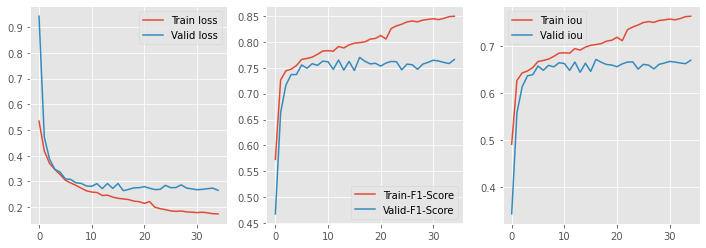

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

## Unet- 3Layers  CNN Keeping same model as Base

In [ ]:
img_size = 128
num_classes = 2

In [ ]:
def conv2d_block(input_tensor, n_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

        # Third layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [ ]:
def build_unet(input_img, n_filters=16, dropout=0.1):

    #ENCODER - DOWNSAMPLE the image - 128x128x1

    #First Block
    c1 = conv2d_block(input_img, n_filters*1) #128x128x16
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) #64x64x16
    p1 = tf.keras.layers.Dropout(dropout)(p1) #64x64x16
    #output will be 64x64x16 for image size 128x128x1

    #Second Block
    c2 = conv2d_block(p1, n_filters*2) #64x64x32
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) #32x32x32
    p2 = tf.keras.layers.Dropout(dropout)(p2)
    #output will be 32x32x32

    #Third Block
    c3 = conv2d_block(p2, n_filters*4) #32x32x64
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3) #16x16x64
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    #output will be 16x16x64

    #Fourth Block
    c4 = conv2d_block(p3, n_filters*8) #16x16x128
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)
    ##output will be 8x8x128 

    #Fifth Block
    c5 = conv2d_block(p4, n_filters*16)
    #output will be 8x8x256

    #We now have output of Encoder

    #DECODER - UPSAMPLE the feature to generate mask

    #First Block - connected to fourth block on DOWNSAMPLE side
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), 
                                         strides = (2, 2), 
                                         padding = 'same')(c5) #16x16x128
    #Skip connection
    u6 = tf.keras.layers.concatenate([u6, c4]) #16x16x256
    u6 = tf.keras.layers.Dropout(dropout)(u6) 
    c6 = conv2d_block(u6, n_filters * 8) #16x16x128

    #Second Block - connected to third block on DOWNSAMPLE side
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6) #32x32x64
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4)

    #Third Block - connected to second block on DOWNSAMPLE side
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7) #64x64x32
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2) 

    #Fourth Block - connected to first block on DOWNSAMPLE side
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8) #128x128x16
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1) #128 x 128 x 16

    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9) #128x128x2

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
#Clear out notebook session
tf.keras.backend.clear_session()

#Define input layer
input_img = tf.keras.layers.Input((img_size, img_size, 1), name='input_img')

#Build model
model2 = build_unet(input_img, dropout=.3)

#Compile model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_img[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
import segmentation_models as sm
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics)

In [ ]:
valbatch = 32
trainbatch=64

In [ ]:
train_generator = batch_generator('image_jpeg',train_df,batch_size=trainbatch)
val_generator = batch_generator('image_jpeg',val_df, batch_size=valbatch)

In [ ]:
train_generator_clache = batch_generator('image_clache',train_df,batch_size=trainbatch)
val_generator_clache = batch_generator('image_clache',val_df, batch_size=valbatch)

In [ ]:
train_generator_hist = batch_generator('image_hist',train_df,batch_size=trainbatch)
val_generator_hist = batch_generator('image_hist',val_df, batch_size=valbatch)

### No Normalization

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_nonorm = [
    keras.callbacks.ModelCheckpoint('Mask_No_Normalization-3layerCNN-16filters.h5', save_weights_only=False,mode="min", save_best_only=True,
                                    monitor='val_loss',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min")
]

In [ ]:
history = model2.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_nonorm],
          epochs=30)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.6017 - iou_score: 0.3887 - f1-score: 0.4669
Epoch 1: val_loss improved from inf to 0.63950, saving model to Mask_No_Normalization-3layerCNN-16filters.h5
152/152 [==============================] - 234s 2s/step - loss: 0.6017 - iou_score: 0.3887 - f1-score: 0.4669 - val_loss: 0.6395 - val_iou_score: 0.2890 - val_f1-score: 0.3938 - lr: 1.0000e-04
Epoch 2/30
152/152 [==============================] - ETA: 0s - loss: 0.5283 - iou_score: 0.5300 - f1-score: 0.6047
Epoch 2: val_loss did not improve from 0.63950
152/152 [==============================] - 231s 2s/step - loss: 0.5283 - iou_score: 0.5300 - f1-score: 0.6047 - val_loss: 0.7369 - val_iou_score: 0.2530 - val_f1-score: 0.3760 - lr: 1.0000e-04
Epoch 3/30
152/152 [==============================] - ETA: 0s - loss: 0.4695 - iou_score: 0.6016 - f1-score: 0.7049
Epoch 3: val_loss improved from 0.63950 to 0.51013, saving model to Mask_No_Normalization-3layerCNN-16filters.

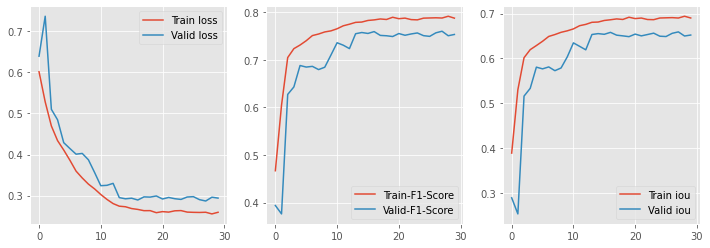

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

### CLACHE Normalization

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_calche = [
    keras.callbacks.ModelCheckpoint('Mask_clache_Normalization-3layerCNN-16filters.h5', save_weights_only=False,mode="min", save_best_only=True,
                                    monitor='val_loss',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min")
]

In [ ]:
history = model2.fit(train_generator_clache,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator_clache, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_calche],
          epochs=30)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.6263 - iou_score: 0.3832 - f1-score: 0.4728 
Epoch 1: val_loss improved from inf to 0.68982, saving model to Mask_clache_Normalization-3layerCNN-16filters.h5
152/152 [==============================] - 2264s 15s/step - loss: 0.6263 - iou_score: 0.3832 - f1-score: 0.4728 - val_loss: 0.6898 - val_iou_score: 0.4366 - val_f1-score: 0.5101 - lr: 1.0000e-04
Epoch 2/30
152/152 [==============================] - ETA: 0s - loss: 0.5109 - iou_score: 0.6145 - f1-score: 0.7129
Epoch 2: val_loss did not improve from 0.68982
152/152 [==============================] - 970s 6s/step - loss: 0.5109 - iou_score: 0.6145 - f1-score: 0.7129 - val_loss: 0.9307 - val_iou_score: 0.3957 - val_f1-score: 0.5164 - lr: 1.0000e-04
Epoch 3/30
152/152 [==============================] - ETA: 0s - loss: 0.4607 - iou_score: 0.6344 - f1-score: 0.7354
Epoch 3: val_loss improved from 0.68982 to 0.61589, saving model to Mask_clache_Normalization-3layerCNN

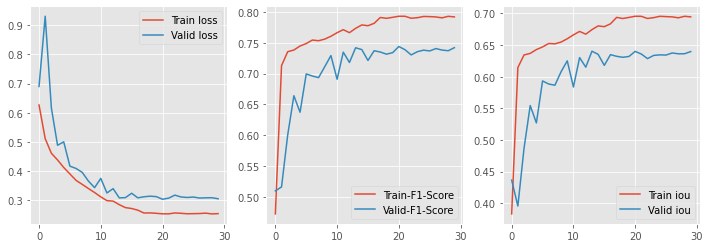

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

### Predicting mask

### Random Prediction of Masks

In [ ]:
def mask_prediction(path,weights,img_num, df):

    #Read image and corresponding mask
    img = tf.keras.preprocessing.image.load_img(path +'/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')
    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')

    #Model prediction
    test_img = img.resize((img_size, img_size))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
    test_img = np.expand_dims(test_img, axis=0) #1,128,128,1

    model2.load_weights(weights)

    pred = model2.predict(test_img) #1,128,128,num_classes
    
    predicted_classes = np.argmax(pred[0], axis=-1)
    
    #Create a pyplot with two images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))

    #Show both images
    ax1.set_title(path)
    ax1.imshow(img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Actual Mask')
    ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax3.set_title('Predicted Mask'+' of '+path)
    ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


    plt.show()

In [ ]:
def random_predictions(number,df):
    i=0
    plt.figure(figsize=(10,10))
    for i in range(number):
        #plt.subplot(3, 3, i+1)
        img_num = np.random.randint(0, val_df.shape[0])
        mask_prediction('image_jpeg','Mask_No_Normalization-3layerCNN-16filters.h5',img_num, df)
        mask_prediction('image_clache','Mask_clache_Normalization-3layerCNN-16filters.h5',img_num, df)

<Figure size 720x720 with 0 Axes>

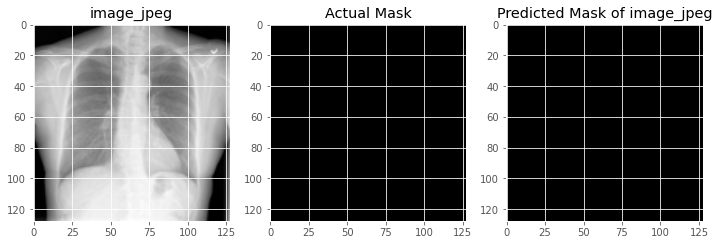

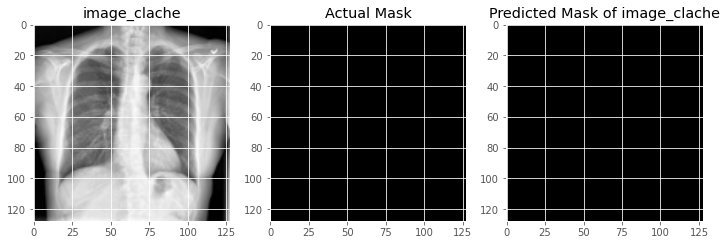

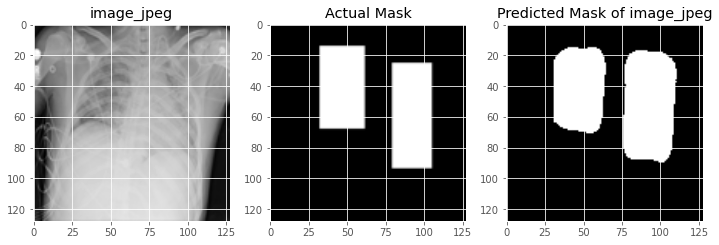

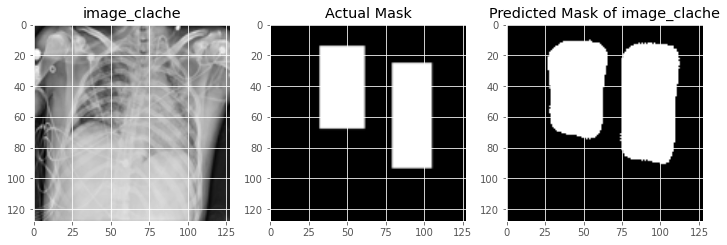

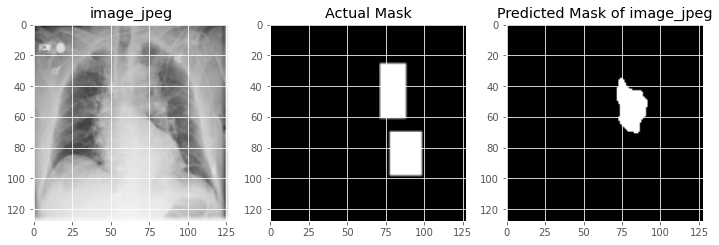

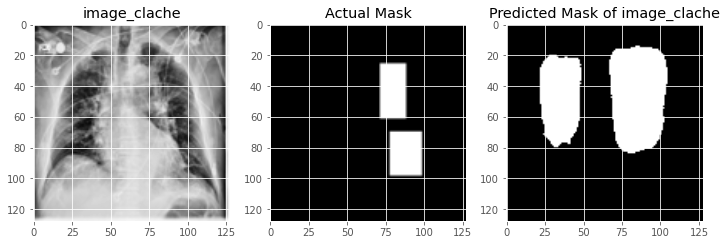

In [ ]:
random_predictions(3,val_df)

# Image Augmentation

In [ ]:
import albumentations as A
import cv2

transform = A.Compose([
    A.HorizontalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(20),
    A.VerticalFlip(p=0.1),
    A.RandomScale(p=0.1,scale_limit=0.05),
    A.GaussNoise(),
    A.Blur(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=30,p=0.2),
])

In [ ]:
def display_image_mask_aug(img_num, df,path):

    #Create a pyplot with two images
    fig, ax = plt.subplots(2, 2, figsize = (10, 6))

    #Read  image and corresponding mask
    img = tf.keras.preprocessing.image.load_img(path+'/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')

    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')
    
    patient=df.loc[img_num, 'patientId']

    img = np.array(img)

    mask_img = np.array(mask_img)

    # Augmentation
    #transformed = transform(image=image, mask=mask)
    transformed = transform(image=img, mask=mask_img)
    transformed_image = transformed['image']
    transformed_mask = transformed['mask']
    #Show both images
    ax[0, 0].set_title(path)
    ax[0, 0].imshow(img, cmap = 'gray', interpolation = 'bilinear')
    ax[0, 0].axis('on')
  
    ax[0, 1].set_title('Mask')
    ax[0, 1].imshow(mask_img, cmap = 'gray', interpolation = 'bilinear')
    ax[0, 1].axis('on')

    ax[1, 0].set_title(path+' '+ 'with Augmentation')
    ax[1, 0].imshow(transformed_image, cmap = 'gray', interpolation = 'nearest')
    ax[1, 0].axis('on')
  
    ax[1, 1].set_title('Mask'+' '+ 'with Augmentation')
    ax[1, 1].imshow(transformed_mask, cmap = 'gray', interpolation = 'nearest')
    ax[1, 1].axis('on')

    
    plt.show()

In [ ]:
import imgaug as ia                                        # Import imgaug library
from imgaug import augmenters as iaa                       # Import augmenters
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
aug = iaa.OneOf([
    iaa.Affine(rotate=(20)),
    iaa.Affine(rotate=(-20)),
    #iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.Affine(translate_px={"x": 100, "y": 100}),
    #iaa.Add(50, per_channel=True),
    #iaa.Affine(scale=(0.055, 0.05)),
    iaa.GaussianBlur(sigma=(0, 1.0)),
    iaa.Affine(shear=(-15, 15)),
    iaa.Sharpen(alpha=0.1)]
)

In [ ]:
def display_image_mask_aug(img_num, df,path):

    #Create a pyplot with two images
    fig, ax = plt.subplots(2, 2, figsize = (10, 6))

    #Read  image and corresponding mask
    img = tf.keras.preprocessing.image.load_img(path+'/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')

    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')
    
    patient=df.loc[img_num, 'patientId']

    img = np.array(img)

    mask_img = np.array(mask_img)

    #Augmentation

    aug_det = aug.to_deterministic()

    image_aug = aug_det.augment_images([img])[0]
    mask_aug = aug_det.augment_images([mask_img])[0]


    ax[0, 0].set_title(path)
    ax[0, 0].imshow(img, cmap = 'gray', interpolation = 'bilinear')
    ax[0, 0].axis('on')
  
    ax[0, 1].set_title('Mask')
    ax[0, 1].imshow(mask_img, cmap = 'gray', interpolation = 'bilinear')
    ax[0, 1].axis('on')

    ax[1, 0].set_title(path+' '+ 'with Augmentation')
    ax[1, 0].imshow(image_aug, cmap = 'gray', interpolation = 'nearest')
    ax[1, 0].axis('on')
  
    ax[1, 1].set_title('Mask'+' '+ 'with Augmentation')
    ax[1, 1].imshow(mask_aug, cmap = 'gray', interpolation = 'nearest')
    ax[1, 1].axis('on')

    
    plt.show()

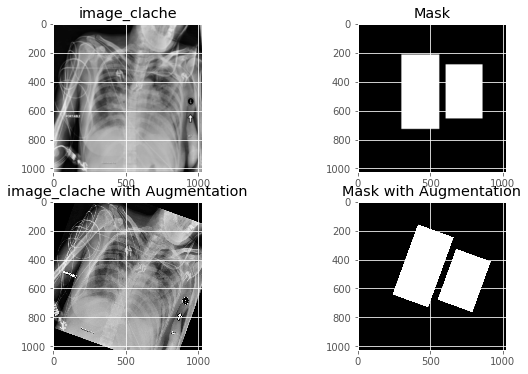

In [ ]:
img_num = np.random.randint(0, train_df.shape[0])
display_image_mask_aug(img_num, train_df,'image_clache')

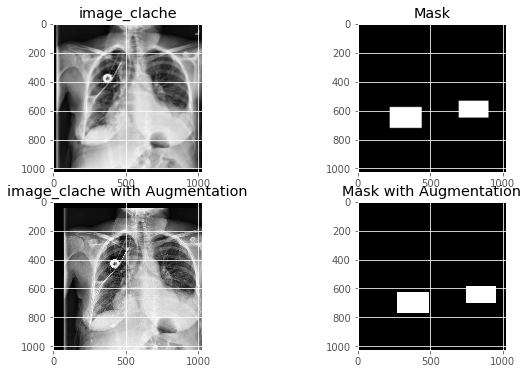

In [ ]:
img_num = np.random.randint(0, train_df.shape[0])
display_image_mask_aug(img_num, train_df,'image_clache')

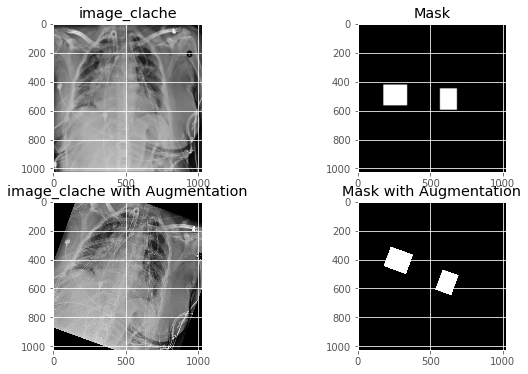

In [ ]:
img_num = np.random.randint(0, train_df.shape[0])
display_image_mask_aug(img_num, train_df,'image_clache')

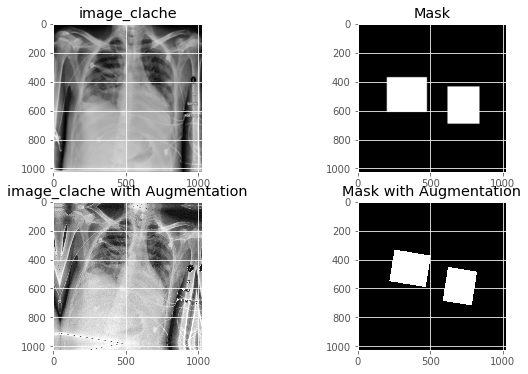

In [ ]:
img_num = np.random.randint(0, train_df.shape[0])
display_image_mask_aug(img_num, train_df,'image_clache')


### Batch generator for Train data with Augmentation

In [ ]:
img_size = 128
num_classes = 2

In [ ]:
def batch_generator_aug(path,df, batch_size=32):

    while True:

        #Create random indexes
        idx = np.random.randint(0, df.shape[0], batch_size)

        #Initialize numpy arrays for X and y
        #Input image is size img_size,img_size,1
        #X = np.zeros((batch_size, img_size, img_size,3))
        X = np.zeros((batch_size, img_size, img_size, 1), dtype=np.float32)
        #Mask's size is img_size, img_size, 1
        y = np.zeros((batch_size, img_size, img_size,num_classes))

        #Populate X and y with actual data
        for i in range(len(idx)):

            #Read image
            img = tf.keras.preprocessing.image.load_img(path+'/' + df.loc[idx[i],'patientId'] + '.jpg', 
                                                        color_mode='grayscale',
                                                        target_size=(img_size, img_size))
            img = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')/255.0



            



            #Read mask
            mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[idx[i],'patientId'] + '.jpg',
                                                            color_mode = 'grayscale',
                                                            target_size=(img_size, img_size))
            #mask_img = np.array(mask_img)
            mask_img = tf.keras.preprocessing.image.img_to_array(mask_img).astype('uint8')/255.0

            

                        #Augmentation
            if i % 2 ==0.0:
                aug_det = aug.to_deterministic()
                img = aug_det.augment_images([img])[0]
                mask_img = aug_det.augment_images([mask_img])[0]

            mask_img = tf.keras.utils.to_categorical(mask_img, num_classes=num_classes)
            #mask_img = tf.keras.preprocessing.image.img_to_array(mask_img)

            X[i] = img

            y[i] = mask_img


        yield X, y

In [ ]:
def batch_generator(path,df, batch_size=32):

    while True:

        #Create random indexes
        idx = np.random.randint(0, df.shape[0], batch_size)

        #Initialize numpy arrays for X and y
        #Input image is size img_size,img_size,1
        #X = np.zeros((batch_size, img_size, img_size,3))
        X = np.zeros((batch_size, img_size, img_size, 1), dtype=np.float32)
        #Mask's size is img_size, img_size, 1
        y = np.zeros((batch_size, img_size, img_size,num_classes))
        #y = np.zeros((batch_size, img_size, img_size,1))

        #Populate X and y with actual data
        for i in range(len(idx)):

            #Read image
            img = tf.keras.preprocessing.image.load_img(path+'/' + df.loc[idx[i],'patientId'] + '.jpg', color_mode='grayscale',
                                                        target_size=(img_size, img_size))
            img = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')/255.0

            X[i] = img

            #Read mask
            mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[idx[i],'patientId'] + '.jpg',
                                                            color_mode = 'grayscale',
                                                            target_size=(img_size, img_size))
            mask_img = tf.keras.preprocessing.image.img_to_array(mask_img).astype('uint8')/255.0
            mask_img = tf.keras.utils.to_categorical(mask_img, num_classes=num_classes)

            y[i] = mask_img

        yield X, y

In [ ]:
valbatch = 32
trainbatch=64

In [ ]:
train_generator = batch_generator_aug('image_jpeg',train_df,batch_size=trainbatch)
val_generator = batch_generator('image_jpeg',val_df, batch_size=valbatch)

In [ ]:
x, y = next(train_generator)

In [ ]:
print(x.shape)
print(y.shape)

(64, 128, 128, 1)
(64, 128, 128, 2)


In [ ]:
train_generator_clache = batch_generator_aug('image_clache',train_df,batch_size=trainbatch)
val_generator_clache = batch_generator('image_clache',val_df, batch_size=valbatch)

# Model with 3CNN layers with Augmentation + 16Filters

In [ ]:
img_size = 128
num_classes = 2

In [ ]:
def conv2d_block(input_tensor, n_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # second layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

        # Third layer
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [ ]:
def build_unet(input_img, n_filters=16, dropout=0.1):

    #ENCODER - DOWNSAMPLE the image - 128x128x1

    #First Block
    c1 = conv2d_block(input_img, n_filters*1) #128x128x16
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1) #64x64x16
    p1 = tf.keras.layers.Dropout(dropout)(p1) #64x64x16
    #output will be 64x64x16 for image size 128x128x1

    #Second Block
    c2 = conv2d_block(p1, n_filters*2) #64x64x32
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2) #32x32x32
    p2 = tf.keras.layers.Dropout(dropout)(p2)
    #output will be 32x32x32

    #Third Block
    c3 = conv2d_block(p2, n_filters*4) #32x32x64
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3) #16x16x64
    p3 = tf.keras.layers.Dropout(dropout)(p3)
    #output will be 16x16x64

    #Fourth Block
    c4 = conv2d_block(p3, n_filters*8) #16x16x128
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)
    ##output will be 8x8x128 

    #Fifth Block
    c5 = conv2d_block(p4, n_filters*16)
    #output will be 8x8x256

    #We now have output of Encoder

    #DECODER - UPSAMPLE the feature to generate mask

    #First Block - connected to fourth block on DOWNSAMPLE side
    u6 = tf.keras.layers.Conv2DTranspose(n_filters * 8, (3, 3), 
                                         strides = (2, 2), 
                                         padding = 'same')(c5) #16x16x128
    #Skip connection
    u6 = tf.keras.layers.concatenate([u6, c4]) #16x16x256
    u6 = tf.keras.layers.Dropout(dropout)(u6) 
    c6 = conv2d_block(u6, n_filters * 8) #16x16x128

    #Second Block - connected to third block on DOWNSAMPLE side
    u7 = tf.keras.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6) #32x32x64
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4)

    #Third Block - connected to second block on DOWNSAMPLE side
    u8 = tf.keras.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7) #64x64x32
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2) 

    #Fourth Block - connected to first block on DOWNSAMPLE side
    u9 = tf.keras.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8) #128x128x16
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1) #128 x 128 x 16

    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9) #128x128x2

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
#Clear out notebook session
tf.keras.backend.clear_session()

#Define input layer
input_img = tf.keras.layers.Input((img_size, img_size, 1), name='input_img')

#Build model
model3 = build_unet(input_img, dropout=.3)

#Compile model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_img[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-po6c0afj
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-po6c0afj
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.2 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=60fcd1cd232a50a04db24fdc54e86e3fc36bac612e21be5ac8262820e20c67f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-la9ekqer/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
import segmentation_models as sm
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics)

### No Normalization

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_nonorm = [
    keras.callbacks.ModelCheckpoint('Mask_No_Normalization-3layerCNN-16filters-Aug.h5', save_weights_only=False,mode="min", save_best_only=True,
                                    monitor='val_loss',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")
]

In [ ]:
history = model3.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_nonorm],
          epochs=30)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.5690 - iou_score: 0.4342 - f1-score: 0.5172
Epoch 1: val_loss improved from inf to 1.27761, saving model to Mask_No_Normalization-3layerCNN-16filters-Aug.h5
152/152 [==============================] - 328s 2s/step - loss: 0.5690 - iou_score: 0.4342 - f1-score: 0.5172 - val_loss: 1.2776 - val_iou_score: 0.0909 - val_f1-score: 0.1651 - lr: 1.0000e-04
Epoch 2/30
152/152 [==============================] - ETA: 0s - loss: 0.4739 - iou_score: 0.5646 - f1-score: 0.6607
Epoch 2: val_loss improved from 1.27761 to 0.64589, saving model to Mask_No_Normalization-3layerCNN-16filters-Aug.h5
152/152 [==============================] - 286s 2s/step - loss: 0.4739 - iou_score: 0.5646 - f1-score: 0.6607 - val_loss: 0.6459 - val_iou_score: 0.4083 - val_f1-score: 0.5279 - lr: 1.0000e-04
Epoch 3/30
152/152 [==============================] - ETA: 0s - loss: 0.4411 - iou_score: 0.5897 - f1-score: 0.6860
Epoch 3: val_loss improved from 0.64

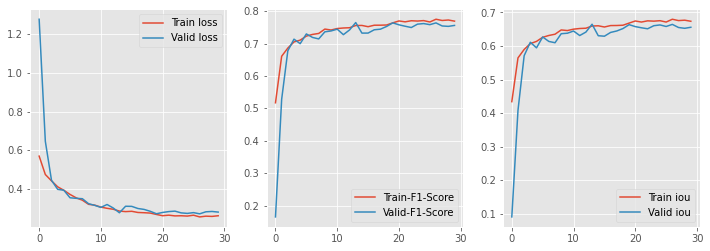

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
def mask_prediction_aug(path,weights,weights_aug,img_num, df):

    #Read image and corresponding mask
    img = tf.keras.preprocessing.image.load_img(path +'/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')
    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg', color_mode='grayscale')

    #Model prediction
    test_img = img.resize((img_size, img_size))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
    test_img = np.expand_dims(test_img, axis=0) #1,128,128,1

    model3.load_weights(weights)

    pred = model3.predict(test_img) #1,128,128,num_classes
    
    predicted_classes = np.argmax(pred[0], axis=-1)

    # Augmentation

    model3.load_weights(weights_aug)

    pred_aug = model3.predict(test_img) #1,128,128,num_classes
    
    predicted_classes_aug = np.argmax(pred_aug[0], axis=-1)
    
    #Create a pyplot with two images
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 8))

    #Show both images
    ax1.set_title(path)
    ax1.imshow(img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Actual Mask')
    ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax3.set_title('Predicted Mask')
    ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')

    ax4.set_title('Predicted Mask'+' '+' With Augmentation')
    ax4.imshow(np.reshape(predicted_classes_aug,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')


    plt.show()

In [ ]:
def random_predictions(number,df):
    i=0
    plt.figure(figsize=(10,10))
    for i in range(number):
        #plt.subplot(3, 3, i+1)
        img_num = np.random.randint(0, val_df.shape[0])
        mask_prediction_aug('image_jpeg','Mask_No_Normalization-3layerCNN-16filters.h5','Mask_No_Normalization-3layerCNN-16filters-Aug.h5',img_num, df)
        

<Figure size 720x720 with 0 Axes>

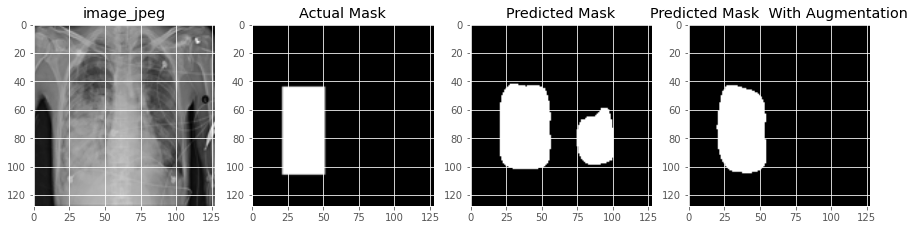

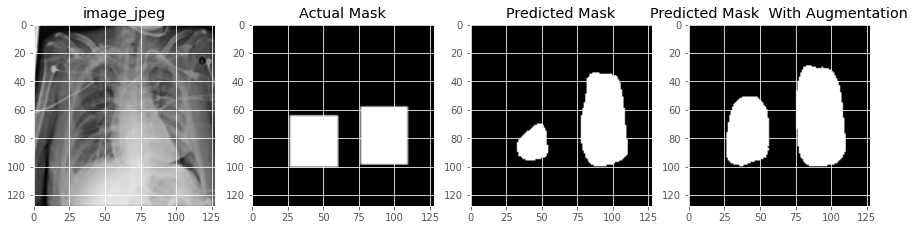

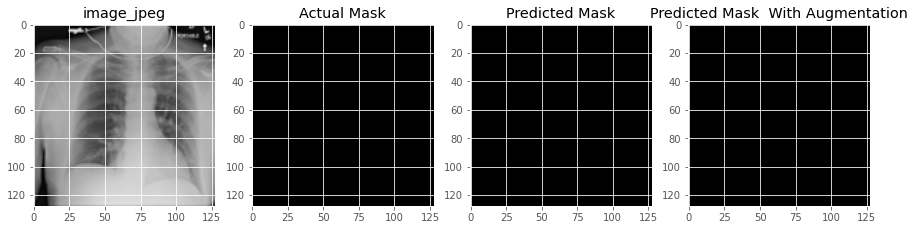

In [ ]:
random_predictions(3,val_df)

###  Using Encoder with Transfer Learning Backbone -ResNet34 with Augmentation

In [ ]:
img_size = 224
num_classes = 2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
#tf.keras.applications.mobilenet_v2.preprocess_input 
import cv2

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ijsi_9cp
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ijsi_9cp
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 4.8 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=95bd2ad0d3df38ddd51b1ed3076dc9ba15fba609202ce07ff7e63eac4cc2ed00
  Stored in directory: /tmp/pip-ephem-wheel-cache-kxjwrkww/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
#Import libraries
import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models import Unet
from segmentation_models.backbones.backbones_factory import Backbones
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

Segmentation Models: using `keras` framework.


In [ ]:
# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16

In [ ]:
# define optomizer
import segmentation_models as sm
# define network parameters
# case for binary and multiclass segmentation
activation = 'sigmoid' if num_classes == 1 else 'softmax'

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
base_model = Unet(backbone_name='resnet34', classes=num_classes,  encoder_weights='imagenet', activation=activation)

85532672/85521592 [==============================] - 2s 0us/step


In [ ]:
# Since X ray images are Gray and Transfer model requires channels of 3 we need to change the input image to 3 channels
from keras.layers import Reshape

inp = Input(shape=(img_size, img_size, 1))

l1 = Conv2D(3, (1, 1))(inp)

out = base_model(l1)

model4 = Model(inp, out, name=base_model.name)

In [ ]:
def batch_generator_aug(path,df, batch_size=32):

    while True:

        #Create random indexes
        idx = np.random.randint(0, df.shape[0], batch_size)

        #Initialize numpy arrays for X and y
        #Input image is size img_size,img_size,1
        #X = np.zeros((batch_size, img_size, img_size,3))
        X = np.zeros((batch_size, img_size, img_size, 1), dtype=np.float32)
        #Mask's size is img_size, img_size, 1
        y = np.zeros((batch_size, img_size, img_size,num_classes))

        #Populate X and y with actual data
        for i in range(len(idx)):

            #Read image
            img = tf.keras.preprocessing.image.load_img(path+'/' + df.loc[idx[i],'patientId'] + '.jpg', 
                                                        color_mode='grayscale',
                                                        target_size=(img_size, img_size))
            img= np.reshape(img.convert('L'), (img_size,img_size,1))
            img = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')/255.0

            img = preprocess_input(img)


            #Read mask
            mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[idx[i],'patientId'] + '.jpg',
                                                            color_mode = 'grayscale',
                                                            target_size=(img_size, img_size))
            #mask_img = np.array(mask_img)
            mask_img = tf.keras.preprocessing.image.img_to_array(mask_img).astype('uint8')/255.0

            

                        #Augmentation
            if i % 2 ==0.0:
                aug_det = aug.to_deterministic()
                img = aug_det.augment_images([img])[0]
                mask_img = aug_det.augment_images([mask_img])[0]

            mask_img = tf.keras.utils.to_categorical(mask_img, num_classes=num_classes)
            #mask_img = tf.keras.preprocessing.image.img_to_array(mask_img)

            X[i] = img

            y[i] = mask_img


        yield X, y

In [ ]:
def batch_generator(path,df, batch_size=32):

    while True:

        #Create random indexes
        idx = np.random.randint(0, df.shape[0], batch_size)

        #Initialize numpy arrays for X and y
        #Input image is size img_size,img_size,1
        
        X = np.zeros((batch_size, img_size, img_size, 1), dtype=np.float32)
        #Mask's size is img_size, img_size, 1
        y = np.zeros((batch_size, img_size, img_size,num_classes))
        #y = np.zeros((batch_size, img_size, img_size,1))

        #Populate X and y with actual data
        for i in range(len(idx)):

            #Read image
            img = tf.keras.preprocessing.image.load_img(path+'/' + df.loc[idx[i],'patientId'] + '.jpg', 
                                                        color_mode='grayscale',
                                                        target_size=(img_size, img_size))
            #img = img.convert('RGB')
            img= np.reshape(img.convert('L'), (img_size,img_size,1))
            
            img = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')/255.0
                  # Normalization when using Resnet34 or any Pretrained model
            img = preprocess_input(img)

            X[i] = img

            #Read mask
            mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[idx[i],'patientId'] + '.jpg',
                                                            color_mode = 'grayscale',
                                                            target_size=(img_size, img_size))
            mask_img = tf.keras.preprocessing.image.img_to_array(mask_img).astype('uint8')/255.0
            mask_img = tf.keras.utils.to_categorical(mask_img, num_classes=num_classes)

            y[i] = mask_img

        yield X, y

In [ ]:
LR = 0.00001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if num_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model4.compile(optim, total_loss, metrics)

In [ ]:
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       6         
                                                                 
 model_1 (Functional)        (None, None, None, 2)     24456299  
                                                                 
Total params: 24,456,305
Trainable params: 24,438,955
Non-trainable params: 17,350
_________________________________________________________________


In [ ]:
valbatch = 32
trainbatch=64

In [ ]:
train_generator = batch_generator_aug('image_jpeg',train_df,batch_size=trainbatch)
val_generator = batch_generator('image_jpeg',val_df, batch_size=valbatch)

In [ ]:
x, y = next(train_generator)

In [ ]:
print(x.shape)
print(y.shape)

(64, 224, 224, 1)
(64, 224, 224, 2)


In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_resnet = [
    keras.callbacks.ModelCheckpoint('Mask_No_Normalization-ResNet-Aug.h5', save_weights_only=False,mode="min", save_best_only=True,
                                    monitor='val_loss',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")
]

In [ ]:
history = model4.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_resnet],
          epochs=30)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.6411 - iou_score: 0.3479 - f1-score: 0.4530
Epoch 1: val_loss improved from inf to 0.57903, saving model to Mask_No_Normalization-ResNet-Aug.h5
152/152 [==============================] - 376s 2s/step - loss: 0.6411 - iou_score: 0.3479 - f1-score: 0.4530 - val_loss: 0.5790 - val_iou_score: 0.4715 - val_f1-score: 0.4875 - lr: 1.0000e-05
Epoch 2/30
152/152 [==============================] - ETA: 0s - loss: 0.5447 - iou_score: 0.5146 - f1-score: 0.6153
Epoch 2: val_loss improved from 0.57903 to 0.54859, saving model to Mask_No_Normalization-ResNet-Aug.h5
152/152 [==============================] - 348s 2s/step - loss: 0.5447 - iou_score: 0.5146 - f1-score: 0.6153 - val_loss: 0.5486 - val_iou_score: 0.4825 - val_f1-score: 0.5225 - lr: 1.0000e-05
Epoch 3/30
152/152 [==============================] - ETA: 0s - loss: 0.4947 - iou_score: 0.5726 - f1-score: 0.6732
Epoch 3: val_loss improved from 0.54859 to 0.53095, saving mod

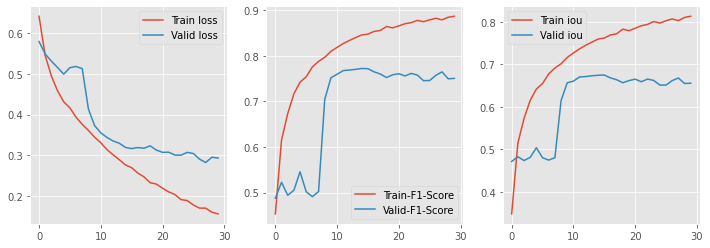

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

###  Using Encoder with Transfer Learning Backbone -ResNet34 With 60% train images
* As the Transfer learning models has lot of parameters it requires more number of training images 
* As we can see there is overfitting if the number of images for training is low


In [ ]:
images_df = pd.read_pickle('images_train_df.pkl')

In [ ]:
train_df = images_df.copy()

In [ ]:
train_df['x'] = train_df['x'].fillna(0)
train_df['y'] = train_df['y'].fillna(0)
train_df['width'] = train_df['width'].fillna(0)
train_df['height'] = train_df['height'].fillna(0)

In [ ]:
train_df['xc'] = train_df['x'] + train_df['width']/2
train_df['yc'] = train_df['y'] + train_df['height']/2

In [ ]:
train_df['Area'] = train_df['height']*train_df['width']

In [ ]:
train_df=train_df.drop(['Rows','Columns'],axis=1)

In [ ]:
train_df.shape

(30227, 14)

In [ ]:
train_dp = train_df.drop_duplicates(subset=['patientId'])

In [ ]:
train_dp_1 =  train_dp.loc[(train_dp['Target'] ==1)]

In [ ]:
train_dp_0 =  train_dp.loc[(train_dp['Target'] ==0)]

In [ ]:
idx = np.random.rand(len(train_dp_0)) < 0.6
train_dp_0 = train_dp_0[idx]

In [ ]:
train_dp_0.shape

(12418, 14)

In [ ]:
train_dp_1.shape

(6012, 14)

In [ ]:
train_dp_downsample=pd.concat([train_dp_0,train_dp_1],axis=0)

In [ ]:
from sklearn.utils import shuffle
train_dp_downsample = shuffle(train_dp_downsample)

In [ ]:
train_dp_downsample.shape

(18430, 14)

In [ ]:
idx = np.random.rand(len(train_dp_downsample)) < 0.8
val_df = train_dp_downsample[~idx]
train_df = train_dp_downsample[idx]
val_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)

In [ ]:
train_df.shape ,val_df.shape

((14703, 15), (3727, 15))

In [ ]:
valbatch = 32
trainbatch=64

In [ ]:
train_generator = batch_generator_aug('image_jpeg',train_df,batch_size=trainbatch)
val_generator = batch_generator('image_jpeg',val_df, batch_size=valbatch)

In [ ]:
x, y = next(train_generator)

In [ ]:
print(x.shape)
print(y.shape)

(64, 224, 224, 1)
(64, 224, 224, 2)


In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_resnet_all = [
    keras.callbacks.ModelCheckpoint('Mask_completetraindata-ResNet-Aug.h5', save_weights_only=False,mode="min", save_best_only=True,
                                    monitor='val_loss',verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")
]

In [ ]:
history = model4.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_resnet_all],
          epochs=25)

Epoch 1/25
229/229 [==============================] - ETA: 0s - loss: 0.6294 - iou_score: 0.4223 - f1-score: 0.5124 
Epoch 1: val_loss improved from inf to 0.55759, saving model to Mask_completetraindata-ResNet-Aug.h5
229/229 [==============================] - 6512s 29s/step - loss: 0.6294 - iou_score: 0.4223 - f1-score: 0.5124 - val_loss: 0.5576 - val_iou_score: 0.4782 - val_f1-score: 0.4889 - lr: 1.0000e-05
Epoch 2/25
229/229 [==============================] - ETA: 0s - loss: 0.5385 - iou_score: 0.5453 - f1-score: 0.6324
Epoch 2: val_loss improved from 0.55759 to 0.54113, saving model to Mask_completetraindata-ResNet-Aug.h5
229/229 [==============================] - 2647s 12s/step - loss: 0.5385 - iou_score: 0.5453 - f1-score: 0.6324 - val_loss: 0.5411 - val_iou_score: 0.4804 - val_f1-score: 0.4900 - lr: 1.0000e-05
Epoch 3/25
229/229 [==============================] - ETA: 0s - loss: 0.4886 - iou_score: 0.6011 - f1-score: 0.6930
Epoch 3: val_loss improved from 0.54113 to 0.53071, sav

In [ ]:
history = model4.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_resnet_all],initial_epoch=25,
          epochs=30)

Epoch 26/30
229/229 [==============================] - ETA: 0s - loss: 0.1457 - iou_score: 0.8005 - f1-score: 0.8763
Epoch 26: val_loss did not improve from 0.29001
229/229 [==============================] - 437s 2s/step - loss: 0.1457 - iou_score: 0.8005 - f1-score: 0.8763 - val_loss: 0.3026 - val_iou_score: 0.6402 - val_f1-score: 0.7265 - lr: 1.0000e-05
Epoch 27/30
229/229 [==============================] - ETA: 0s - loss: 0.1448 - iou_score: 0.7998 - f1-score: 0.8760
Epoch 27: val_loss did not improve from 0.29001
229/229 [==============================] - 429s 2s/step - loss: 0.1448 - iou_score: 0.7998 - f1-score: 0.8760 - val_loss: 0.3025 - val_iou_score: 0.6397 - val_f1-score: 0.7266 - lr: 1.0000e-05
Epoch 28/30
229/229 [==============================] - ETA: 0s - loss: 0.1413 - iou_score: 0.8029 - f1-score: 0.8784
Epoch 28: val_loss improved from 0.29001 to 0.28965, saving model to Mask_completetraindata-ResNet-Aug.h5
229/229 [==============================] - 424s 2s/step - los

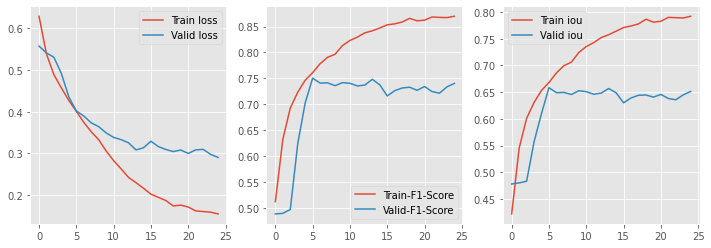

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["f1-score"], label="Train-F1-Score")
plt.plot(history.epoch, history.history["val_f1-score"], label="Valid-F1-Score")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["iou_score"], label="Train iou")
plt.plot(history.epoch, history.history["val_iou_score"], label="Valid iou")
plt.legend()
plt.show()

#### Change of Batch size to check overfitting

In [ ]:
valbatch = 32
trainbatch=16

In [ ]:
train_generator = batch_generator_aug('image_jpeg',train_df,batch_size=trainbatch)
val_generator = batch_generator('image_jpeg',val_df, batch_size=valbatch)

In [ ]:
history = model4.fit(train_generator,
          steps_per_epoch=train_df.shape[0]//trainbatch, 
          validation_data=val_generator, 
          validation_steps=val_df.shape[0]//valbatch, 
          callbacks=[callbacks_resnet_all],initial_epoch=30,
          epochs=50)

Epoch 31/50
918/918 [==============================] - ETA: 0s - loss: 0.1998 - iou_score: 0.7404 - f1-score: 0.8206
Epoch 31: val_loss did not improve from 0.28965
918/918 [==============================] - 421s 458ms/step - loss: 0.1998 - iou_score: 0.7404 - f1-score: 0.8206 - val_loss: 0.2913 - val_iou_score: 0.6488 - val_f1-score: 0.7378 - lr: 1.0000e-05
Epoch 32/50
918/918 [==============================] - ETA: 0s - loss: 0.1936 - iou_score: 0.7459 - f1-score: 0.8240
Epoch 32: val_loss improved from 0.28965 to 0.28818, saving model to Mask_completetraindata-ResNet-Aug.h5
918/918 [==============================] - 422s 460ms/step - loss: 0.1936 - iou_score: 0.7459 - f1-score: 0.8240 - val_loss: 0.2882 - val_iou_score: 0.6500 - val_f1-score: 0.7385 - lr: 1.0000e-05
Epoch 33/50
918/918 [==============================] - ETA: 0s - loss: 0.1796 - iou_score: 0.7579 - f1-score: 0.8363
Epoch 33: val_loss did not improve from 0.28818
918/918 [==============================] - 420s 458ms/s

### Predicting Mask with Resnet with Augmentation - 30% samples of NoPnuemonia Vs 60% Samples of Pnuemonia

In [ ]:
def mask_prediction_transfermodel(path,weights_30,weights_60,img_num, df):

    #test_img = np.zeros((1, img_size, img_size, 3), dtype=np.float32)
    #Read image and corresponding mask
    img = tf.keras.preprocessing.image.load_img('image_jpeg/' + df.loc[img_num, 'patientId'] + '.jpg', 
                                                color_mode='grayscale',target_size=(img_size, img_size))
    mask_img = tf.keras.preprocessing.image.load_img('masks/' + df.loc[img_num, 'patientId'] + '.jpg',
                                                     color_mode='grayscale')

    #Model prediction
    test_img= np.reshape(img.convert('L'), (img_size,img_size,1))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img).astype('uint8')/255.0
    
    test_img = preprocess_input(test_img)
    
    #test_img = np.expand_dims(test_img, axis=2) #1,128,128,1
    test_img = np.expand_dims(test_img, axis=0)
    #pr_mask = model.predict(test_img).round()
    
    #test_img = np.stack((test_img,)*3, axis=-1)
    model4.load_weights(weights_30)
    pred = model4.predict(test_img) #1,128,128,num_classes
    predicted_classes = np.argmax(pred[0], axis=-1)

    model4.load_weights(weights_60)

    pred_aug = model4.predict(test_img) #1,128,128,num_classes
    
    predicted_classes_aug = np.argmax(pred_aug[0], axis=-1)
    
    #Create a pyplot with two images
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (12, 8))

    #Show both images
    ax1.set_title('Image')
    ax1.imshow(img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Actual Mask')
    ax2.imshow(mask_img.resize((img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax3.set_title('Pred Mask 30% Train')
    ax3.imshow(np.reshape(predicted_classes,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    ax4.set_title('Pred Mask 60% Train')
    ax4.imshow(np.reshape(predicted_classes_aug,(img_size, img_size)), cmap = 'gray', interpolation = 'bilinear')
    #ax3.imshow(pr_mask[..., 0].squeeze(), cmap = 'gray', interpolation = 'bilinear')


In [ ]:
def random_predictions_transfermodel(number,df):
    i=0
    plt.figure(figsize=(20,10))
    for i in range(number):
        #plt.subplot(3, 3, i+1)
        img_num = np.random.randint(0, val_df.shape[0])
        mask_prediction_transfermodel('image_jpeg','Mask_No_Normalization-ResNet-Aug.h5','Mask_completetraindata-ResNet-Aug.h5',img_num, df)
        

<Figure size 1440x720 with 0 Axes>

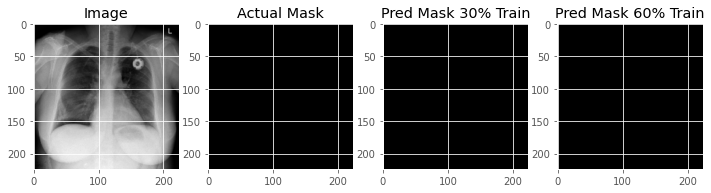

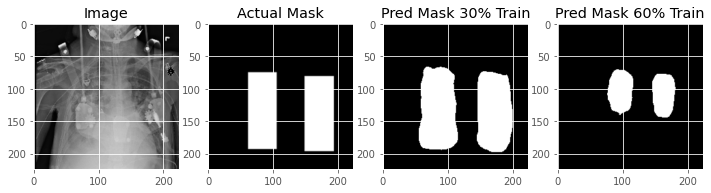

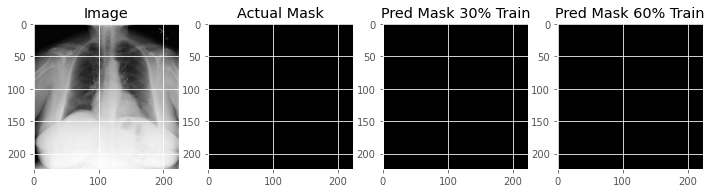

In [ ]:
random_predictions_transfermodel(3,val_df)

<Figure size 1440x720 with 0 Axes>

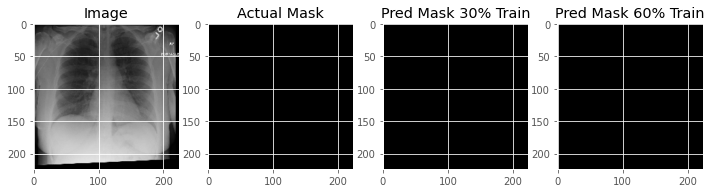

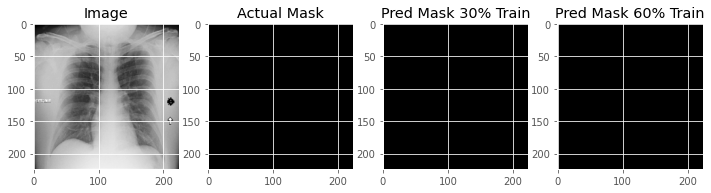

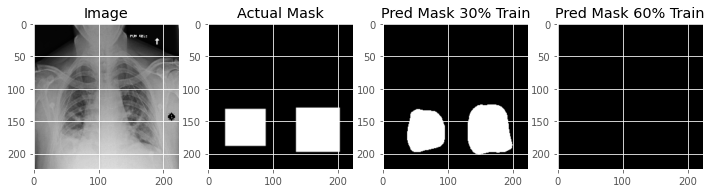

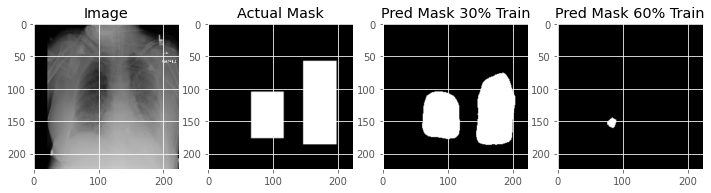

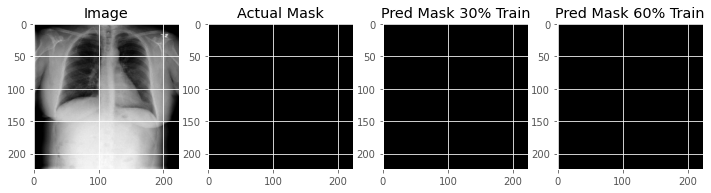

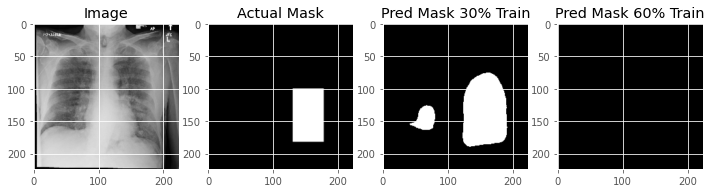

In [ ]:
random_predictions_transfermodel(6,val_df)